In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import chain
sns.set_style('whitegrid')
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
import cesium.featurize as featurize


In [10]:
train_series = pd.read_csv('../input/training_set.csv.zip')
train_metadata = pd.read_csv('../input/training_set_metadata.csv')

In [11]:
def normalise(ts):
    return (ts - ts.mean()) / ts.std()

groups = train_series.groupby(['object_id', 'passband'])
times = groups.apply(
    lambda block: block['mjd'].values).reset_index().rename(columns={0: 'seq'})
flux = groups.apply(
    lambda block: normalise(block['flux']).values
).reset_index().rename(columns={0: 'seq'})
err = groups.apply(
    lambda block: (block['flux_err'] / block['flux'].std()).values
).reset_index().rename(columns={0: 'seq'})
det = groups.apply(
    lambda block: block['detected'].astype(bool).values
).reset_index().rename(columns={0: 'seq'})
times_list = times.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
flux_list = flux.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
err_list = err.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
det_list = det.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()


In [12]:
stds = groups['flux'].std().groupby('object_id').median()
stds.head()

object_id
615     315.102287
713       6.428701
730       6.875735
745      29.009063
1124     21.377240
Name: flux, dtype: float64

In [46]:
def plot_phase(n, fr=None, extra_title='', hide_undetected=False, ax=None):
    selected_times = times_list[n]
    selected_flux = flux_list[n]
    selected_err = err_list[n]
    if hide_undetected:
        selected_det = det_list[n]
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
    if ax is None:
        f, ax = plt.subplots(figsize=(12, 4))
    ax.set_xlabel('time' if fr is None else 'phase')
    for band in range(6):
        if hide_undetected:
            times = selected_times[band][selected_det[band]] \
                if fr is None else (selected_times[band][selected_det[band]] * fr) % 1
            ax.scatter(x=times, 
                       y=selected_flux[band][selected_det[band]], 
                       c=colors[band],
                       s=10)
            ax.vlines(times, 
                      selected_flux[band][selected_det[band]] 
                      - selected_err[band][selected_det[band]],
                      selected_flux[band][selected_det[band]] 
                      + selected_err[band][selected_det[band]],
                      colors=colors[band],
                      linewidth=1)
            
            times = selected_times[band][~selected_det[band]] \
                if fr is None else (selected_times[band][~selected_det[band]] * fr) % 1
            ax.scatter(x=times, 
                       y=selected_flux[band][~selected_det[band]], 
                       c=colors[band],
                       alpha=0.3,
                       s=5)
            ax.vlines(times, 
                      selected_flux[band][~selected_det[band]] 
                      - selected_err[band][~selected_det[band]],
                      selected_flux[band][~selected_det[band]] 
                      + selected_err[band][~selected_det[band]],
                      colors=colors[band],
                      alpha=0.1,
                      linewidth=0.5)
        else:
            times = selected_times[band] if fr is None else (selected_times[band] * fr) % 1
            ax.scatter(x=times, 
                       y=selected_flux[band], 
                       c=colors[band],
                       s=10)
            ax.vlines(times, 
                      selected_flux[band] - selected_err[band],
                      selected_flux[band] + selected_err[band],
                      colors=colors[band],
                      linewidth=1)
    ax.set_ylabel('relative flux')
    ax.set_title(
        f'object: {train_metadata["object_id"][n]}, class: {train_metadata["target"][n]}, '
        f'ddf: {train_metadata["ddf"][n]}, specz: {train_metadata["hostgal_specz"][n]}'
        f', median flux std: {stds[train_metadata["object_id"][n]]:.4}'
        + extra_title)
    if ax is None:
        plt.show()


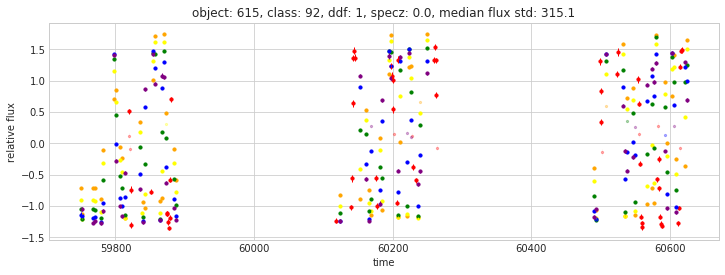

In [47]:
plot_phase(0, hide_undetected=True)

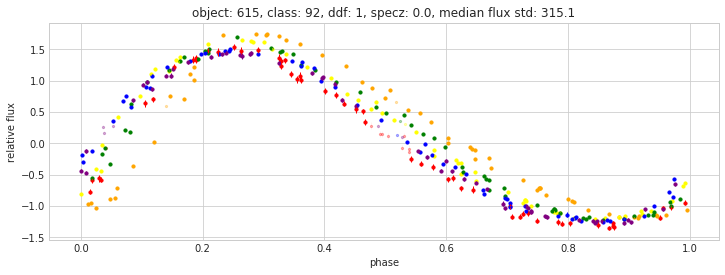

In [50]:
plot_phase(0, 3.0816305735613545, hide_undetected=True)

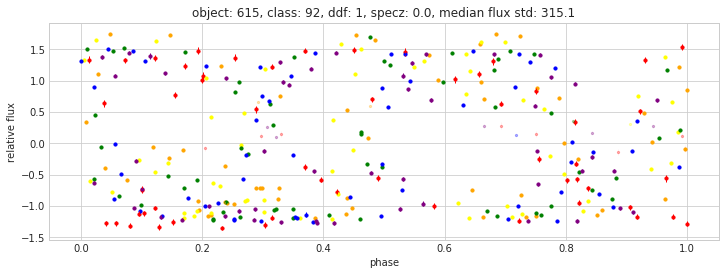

In [54]:
plot_phase(0, 3.08, hide_undetected=True)

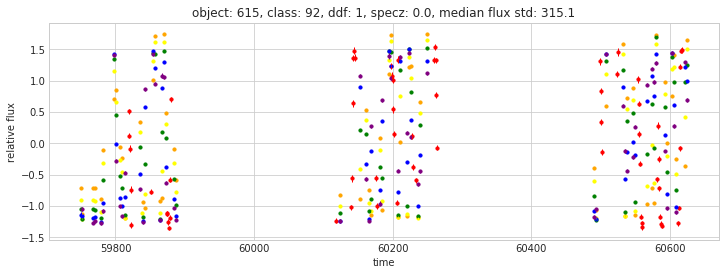

In [40]:
plot_phase(0, hide_undetected=False)

In [61]:
train_series.dtypes

object_id      int64
mjd          float64
passband       int64
flux         float64
flux_err     float64
detected       int64
dtype: object

In [28]:
def get_freq_features(N, subsetting_pos=None):
    if subsetting_pos is None:
        subset_times_list = times_list
        subset_flux_list = flux_list
    else:
        subset_times_list = [v for i, v in enumerate(times_list) 
                             if i in set(subsetting_pos)]
        subset_flux_list = [v for i, v in enumerate(flux_list) 
                            if i in set(subsetting_pos)]
    feats = featurize.featurize_time_series(times=subset_times_list[:N],
                                            values=subset_flux_list[:N],
                                            features_to_use=['freq1_freq',
                                                            'freq1_signif',
                                                            'freq1_amplitude1',
                                                            'skew',
                                                            'percent_beyond_1_std',
                                                            'percent_difference_flux_percentile'],
                                            scheduler=None)
    feats['object_pos'] = subsetting_pos[:N]
    return feats

In [16]:
unique_classes = train_metadata['target'].unique()
unique_classes

array([92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52,  6, 64, 53])

In [57]:
def get_class_feats(label, N=20):
    class_pos = train_metadata[train_metadata['target'] == label].index
    class_feats = get_freq_features(N, class_pos)
    return class_feats


def plot_phase_curves(feats, use_median_freq=False, hide_undetected=True, N=10):
    for i in range(N):
        freq = feats.loc[i, 'freq1_freq'].median()
        freq_min = feats.loc[i, 'freq1_freq'].min()
        freq_std = feats.loc[i, 'freq1_freq'].std()
        skew = feats.loc[i, 'skew'].mean()
        object_pos = int(feats.loc[i, 'object_pos'][0])
        f, ax = plt.subplots(1, 2, figsize=(14, 4))
        plot_phase(object_pos, 
                   fr=None,
                   hide_undetected=hide_undetected, ax=ax[0])
        plot_phase(object_pos, 
                   fr=freq if use_median_freq else freq_min,
                   hide_undetected=hide_undetected, ax=ax[1])
        title = ax[0].get_title()
        ax[0].set_title('time')
        ax[1].set_title('phase')
        f.suptitle(title + f'\nfreq_std: {freq_std:.2}'
                   f', median period: {1/freq: .2}, max period: {1/freq_min: .2}'
                   f', mean skew: {skew:.2}', y=1.1)
        plt.show()

In [29]:
class92_feats = get_class_feats(92)
class92_feats.head(24)


feature freq1_freq                                                    \
channel          0         1         2         3         4         5   
0         3.081631  3.081649  3.081649  3.081649  3.081634  3.081685   
1         1.597659  1.597666  1.597666  1.597648  1.597733  1.597733   
2         1.793083  1.793061  1.793061  1.793061  1.793062  1.793062   
3         1.430330  1.430608  1.430513  2.433249  1.430513  1.430514   
4         1.630779  1.630804  1.630804  1.630713  1.630796  1.630752   
5         2.577927  2.577970  2.577970  2.577970  2.577970  2.577970   
6         1.545549  1.545649  1.545649  1.545631  1.545622  1.545622   
7         1.670685  1.670632  1.670632  1.670632  1.670624  1.670671   
8         1.556682  1.556641  1.556641  1.556641  1.556634  1.556604   
9         3.599702  3.599743  3.599743  3.599702  3.599680  3.599680   
10        3.599702  3.599743  3.599743  3.599702  3.599680  3.599680   
11        1.799226  1.799181  1.799181  1.799181  1.799173  1.799237   
12        1.741172  1.741224  1.741224  1.741224  1.741216  1.741240   
13        3.032099  3.032115  3.032115  3.032115  3.032101  3.032131   
14        1.597691  1.597660  1.597660  1.597660  1.597652  1.597532   
15        1.683115  1.683189  1.683189  1.683266  1.683255  1.683255   
16        1.447163  1.447121  1.447121  1.447104  1.447095  1.447095   
17        1.633241  1.633166  1.633261  1.633148  1.633138  1.633138   
18        3.357959  3.357978  3.357978  3.357978  3.357978  3.357979   
19        2.970937  2.970862  2.970862  2.970862  2.970848  2.970922   

feature freq1_signif                                  ...      \
channel            0         1         2         3    ...       
0           6.158931  5.891056  5.891504  5.889972    ...       
1           6.480537  5.665291  5.658417  5.590074    ...       
2           6.648549  5.738173  5.761654  5.766595    ...       
3           3.912641  4.841859  5.002948  4.848848    ...       
4           6.171748  5.889960  5.888702  5.810384    ...       
5           3.997006  5.099584  5.099783  5.099955    ...       
6           6.355318  5.517718  5.490588  5.691056    ...       
7           5.963694  5.859872  5.837764  5.849806    ...       
8           6.122995  5.888803  5.882729  5.887514    ...       
9           6.545495  5.765815  5.769393  5.778732    ...       
10          6.544861  5.753266  5.766089  5.779288    ...       
11          6.152927  5.854173  5.788010  5.856077    ...       
12          6.018605  5.796744  5.813249  5.809185    ...       
13          6.158529  5.889823  5.889090  5.888581    ...       
14          6.158626  5.712453  5.625332  5.811309    ...       
15          6.270758  5.771856  5.772858  5.768120    ...       
16          6.518818  5.621838  5.519270  5.643267    ...       
17          6.101418  5.751749  5.551158  5.732199    ...       
18          6.640844  5.776690  5.776536  5.774928    ...       
19          6.169703  5.886808  5.887783  5.887162    ...       

feature percent_beyond_1_std                      \
channel                    3         4         5   
0                   0.500000  0.517241  0.561404   
1                   0.285714  0.321429  0.303571   
2                   0.357143  0.339286  0.363636   
3                   0.400000  0.355556  0.400000   
4                   0.344828  0.362069  0.350877   
5                   0.466667  0.488889  0.533333   
6                   0.500000  0.464286  0.410714   
7                   0.189655  0.344828  0.350877   
8                   0.465517  0.396552  0.403509   
9                   0.482143  0.625000  0.517857   
10                  0.500000  0.535714  0.553571   
11                  0.413793  0.327586  0.350877   
12                  0.310345  0.344828  0.403509   
13                  0.517241  0.500000  0.473684   
14                  0.362069  0.379310  0.368421   
15                  0.321429  0.357143  0.375000   
16                  0.410714  0.446429  0.464286

In [31]:
class92_feats.columns

MultiIndex(levels=[['freq1_amplitude1', 'freq1_freq', 'freq1_signif', 'percent_beyond_1_std', 'percent_difference_flux_percentile', 'skew', 'object_pos'], [0, 1, 2, 3, 4, 5, '']],
           labels=[[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 6], [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 6]],
           names=['feature', 'channel'])

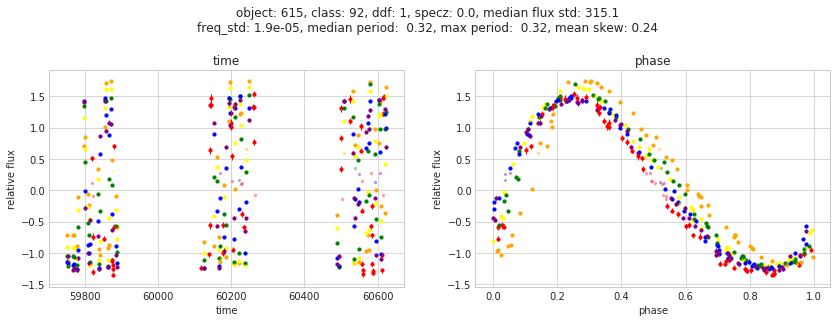

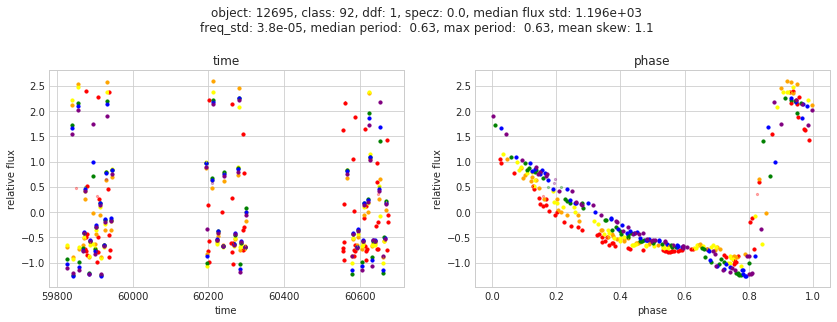

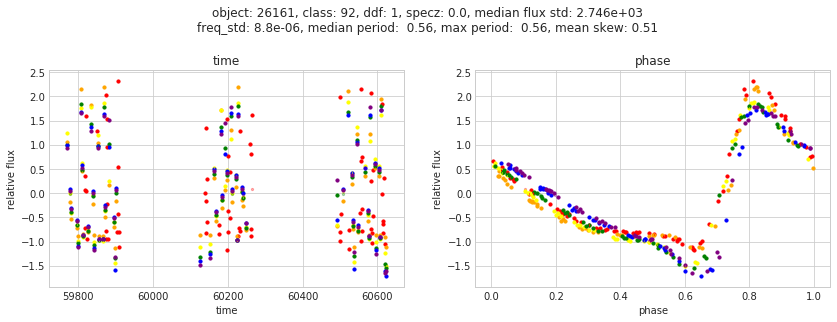

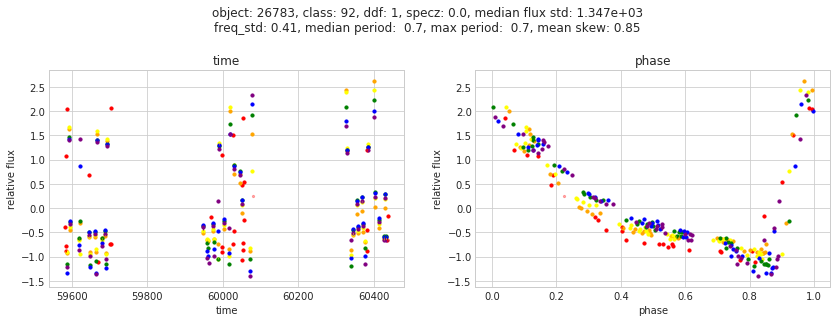

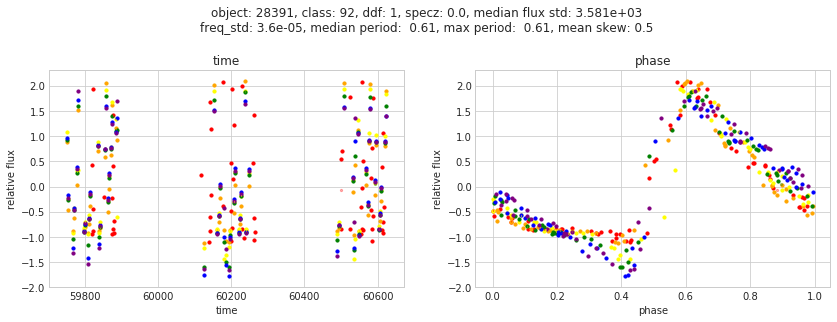

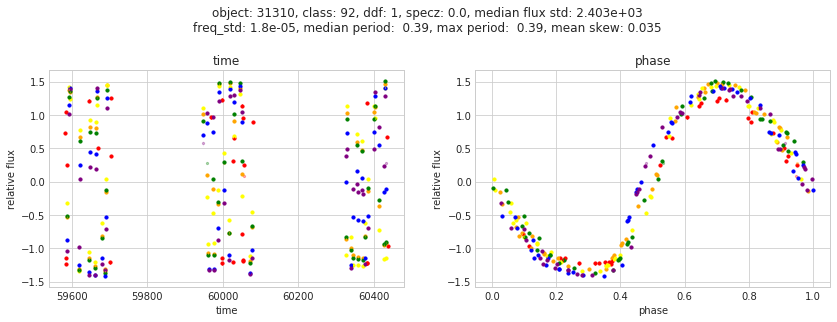

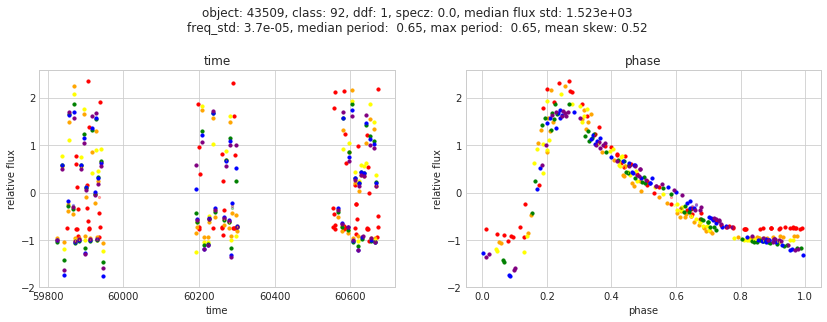

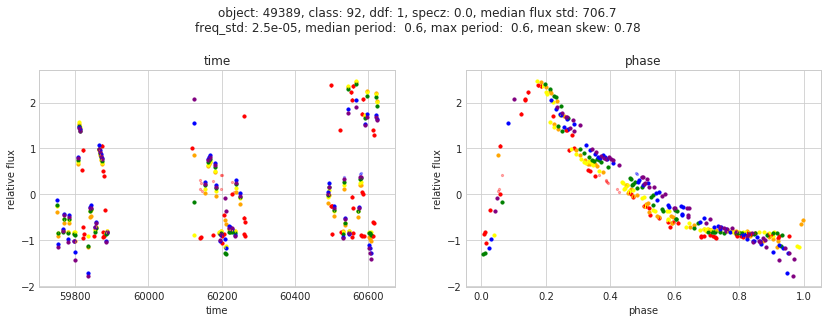

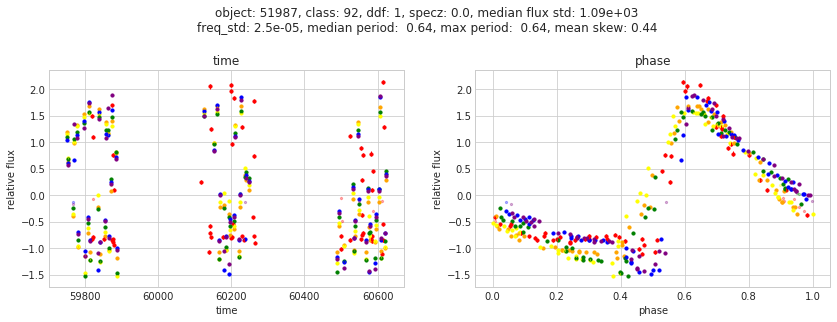

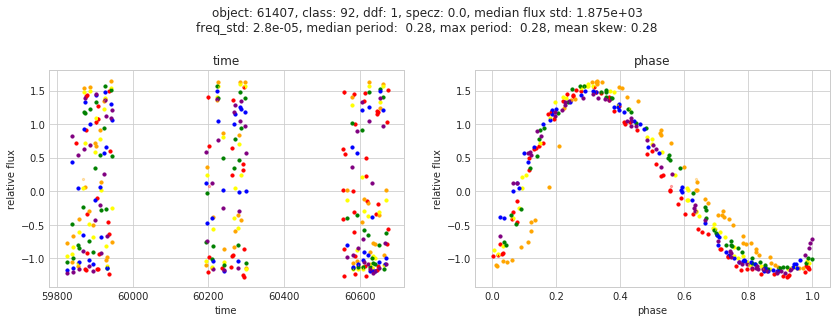

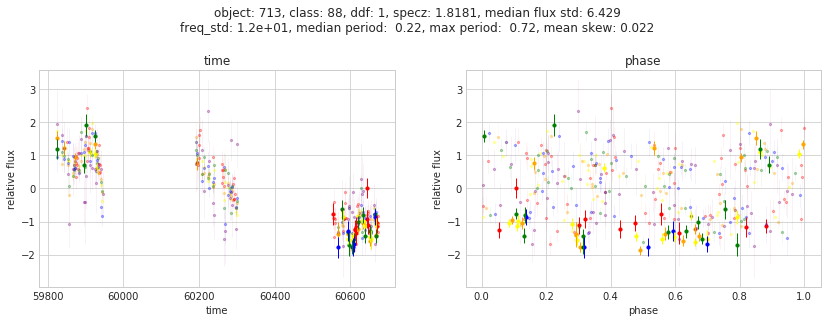

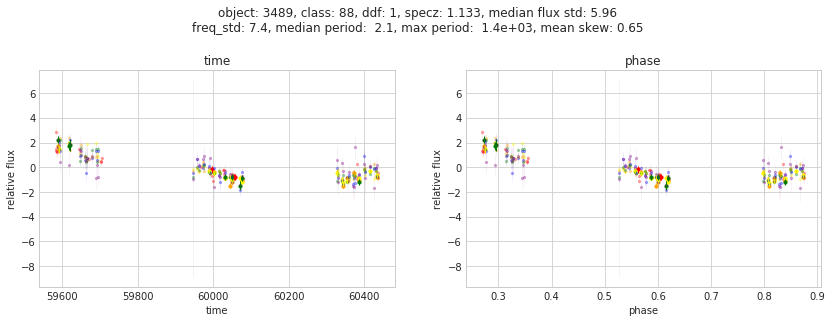

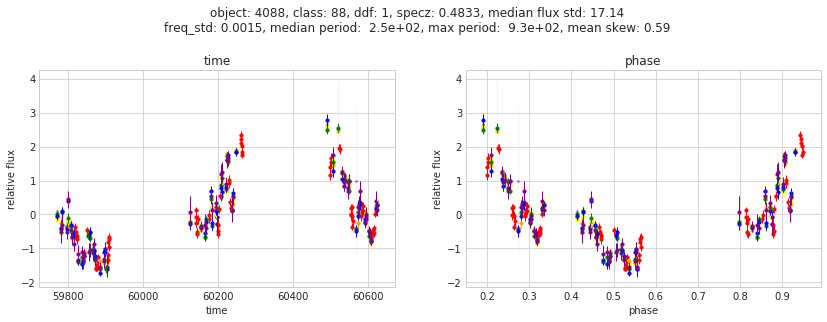

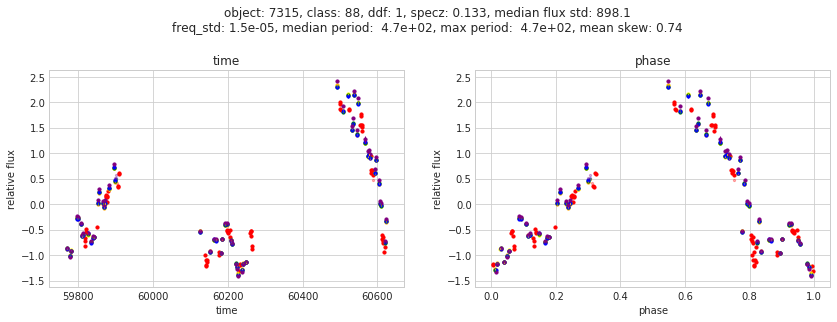

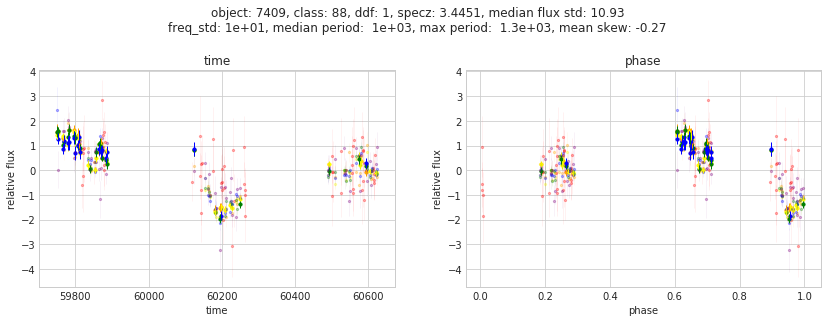

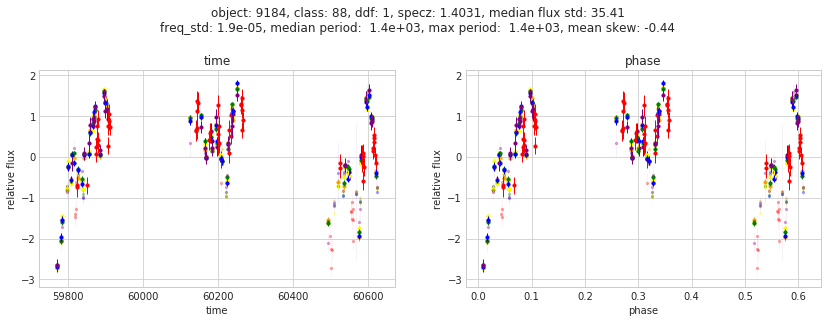

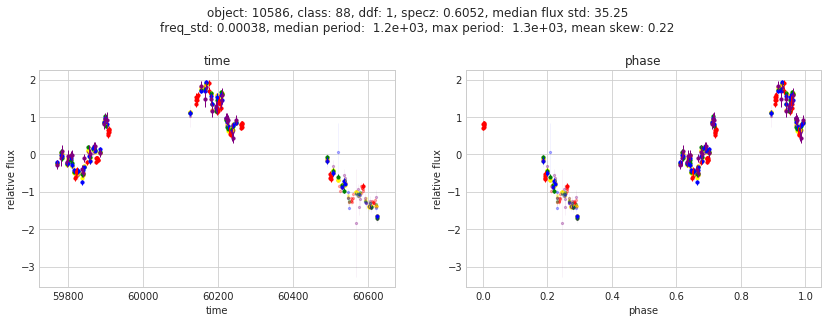

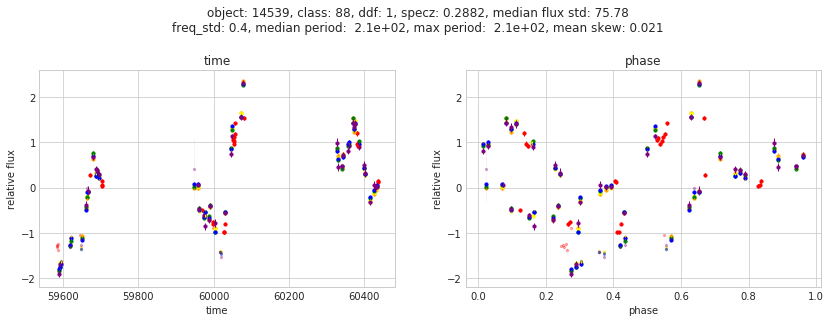

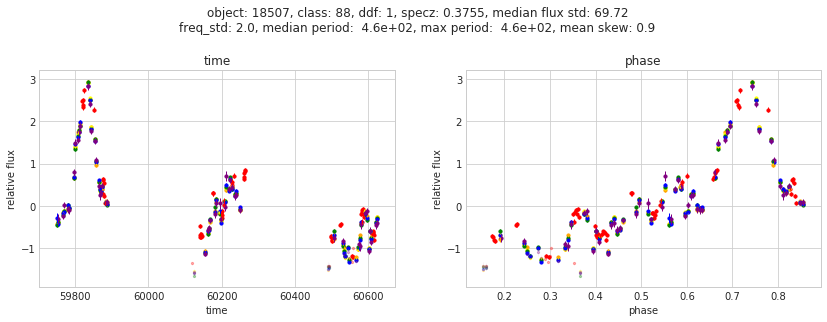

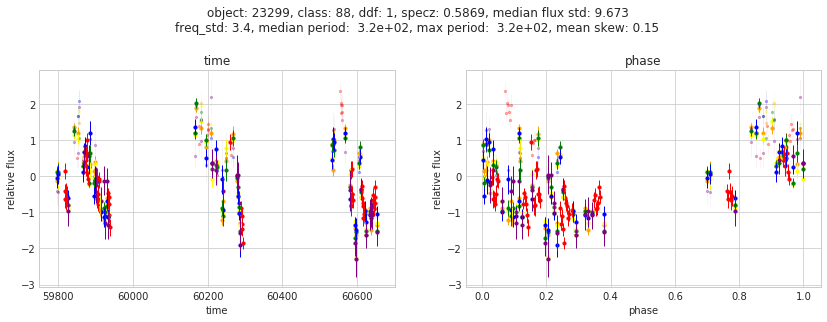

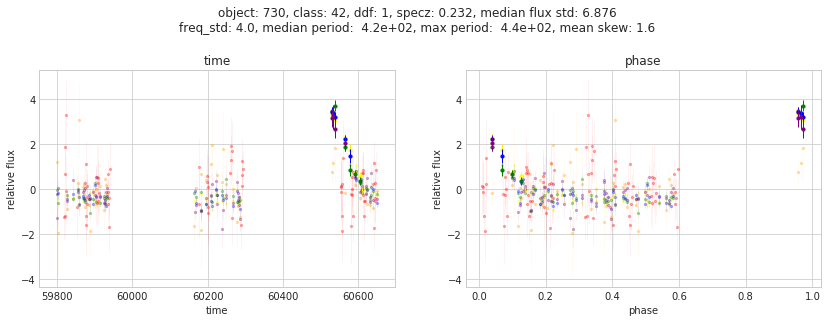

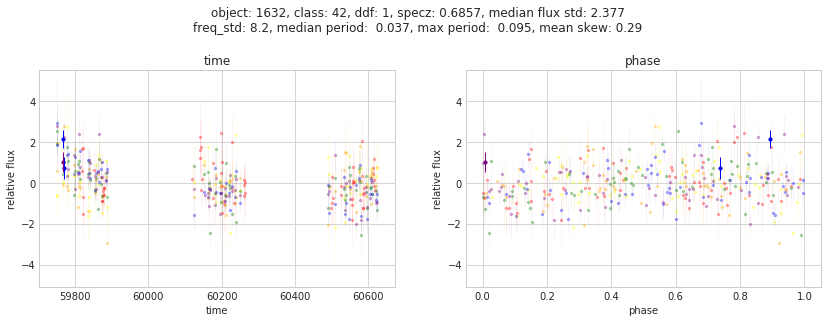

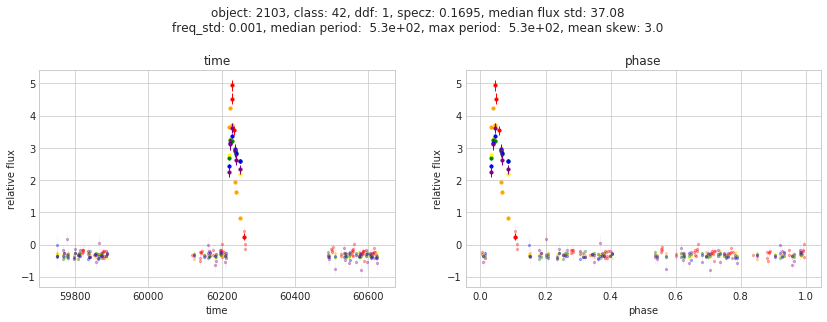

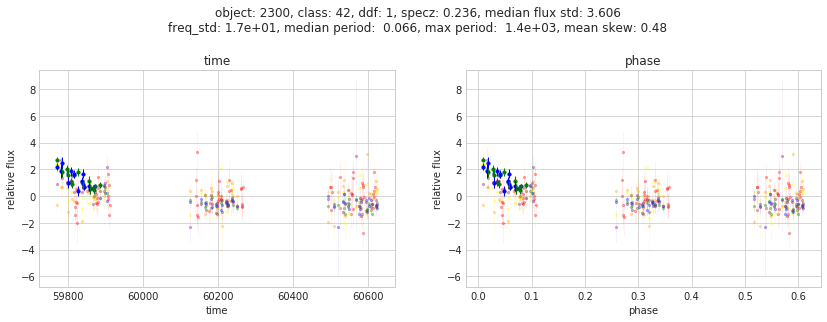

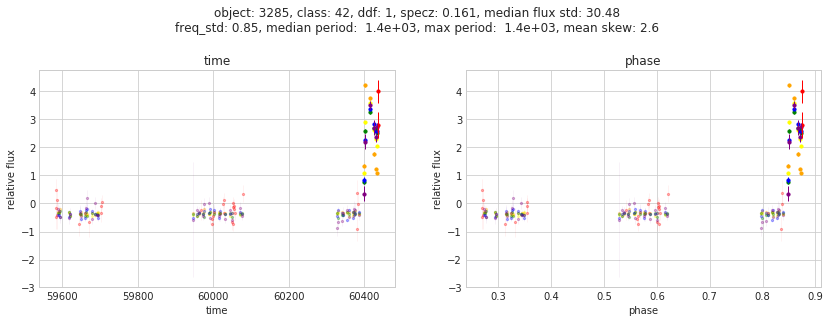

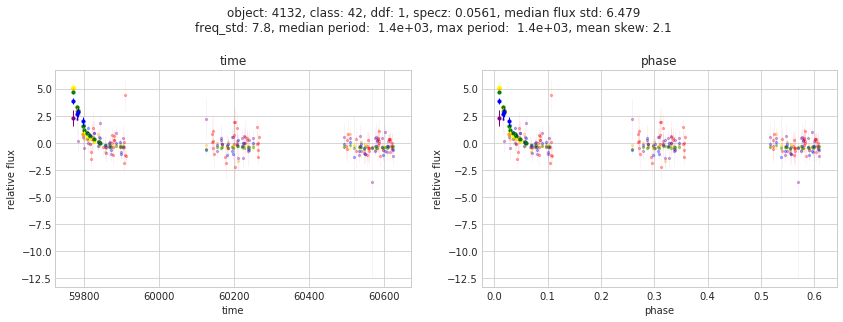

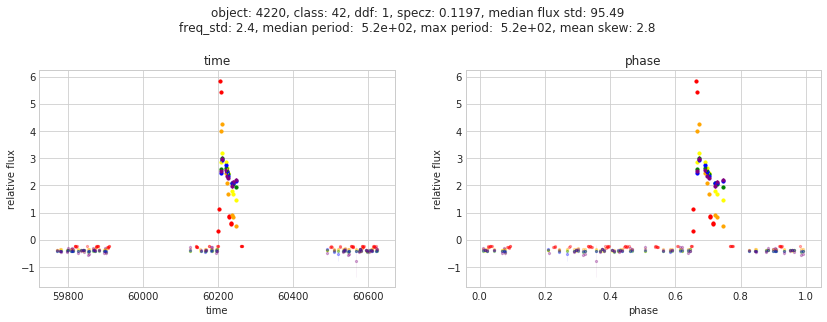

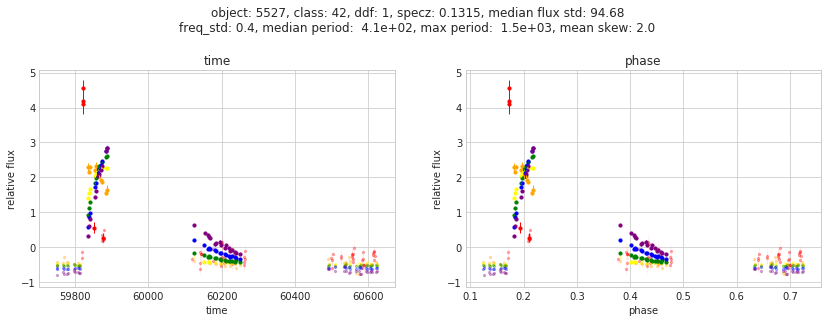

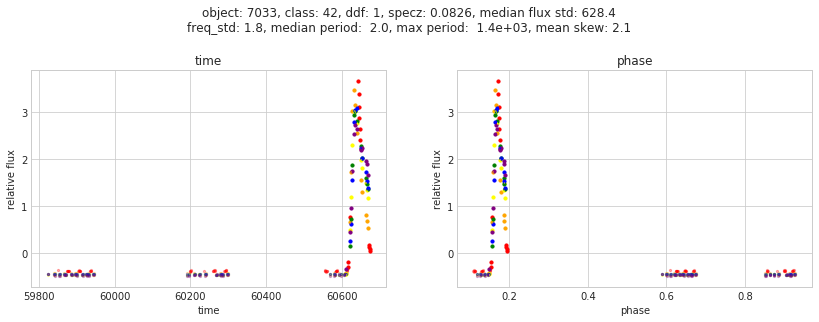

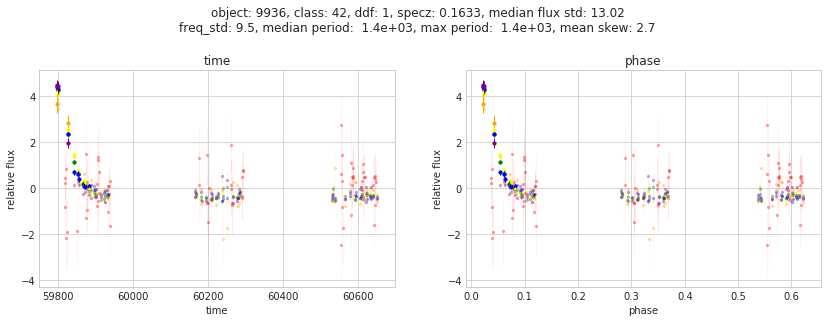

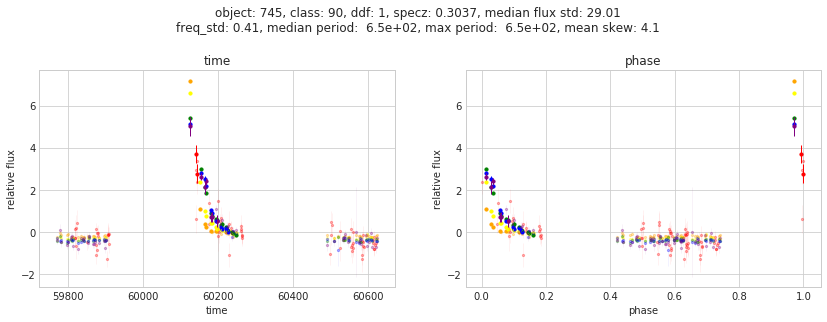

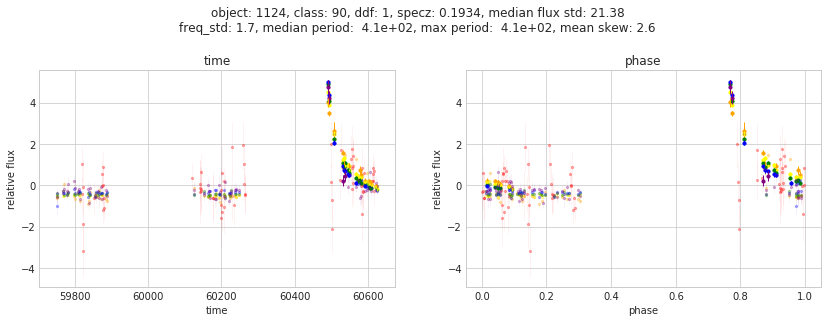

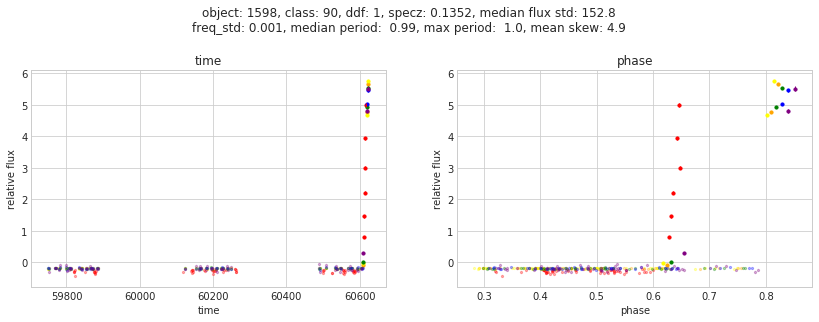

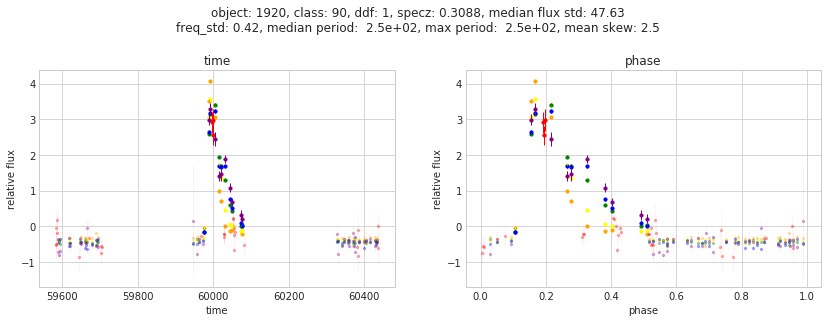

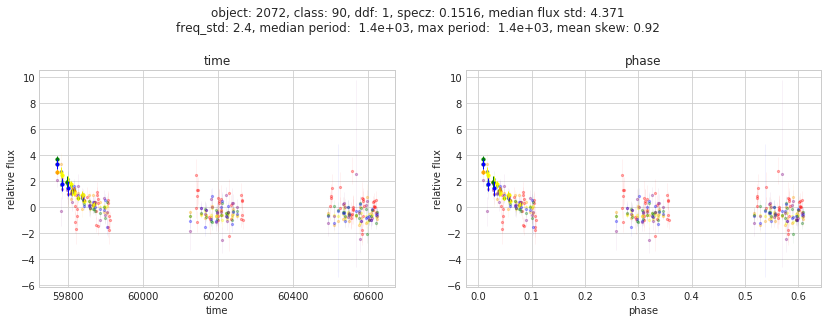

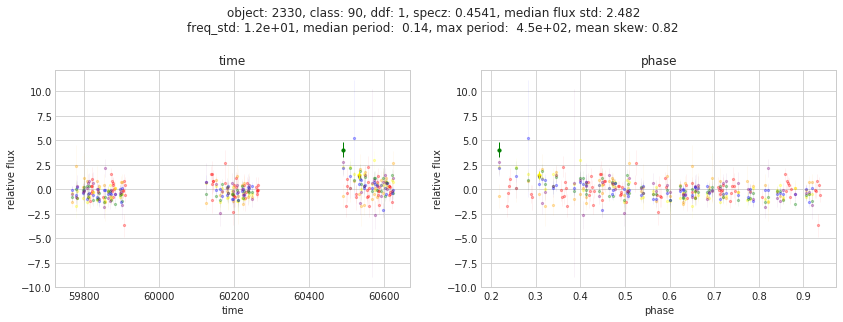

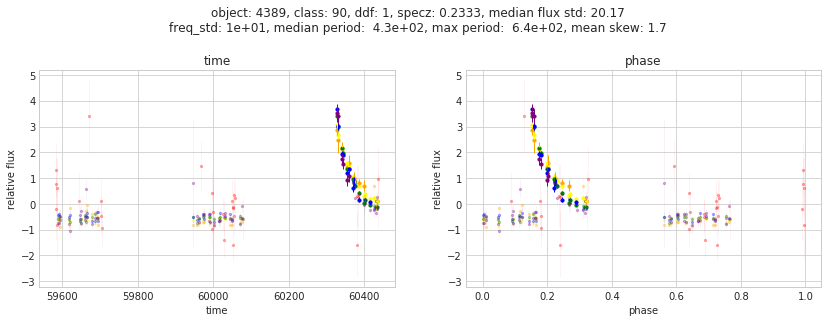

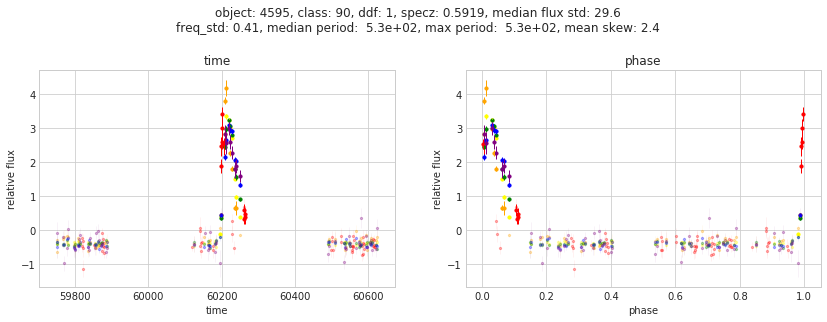

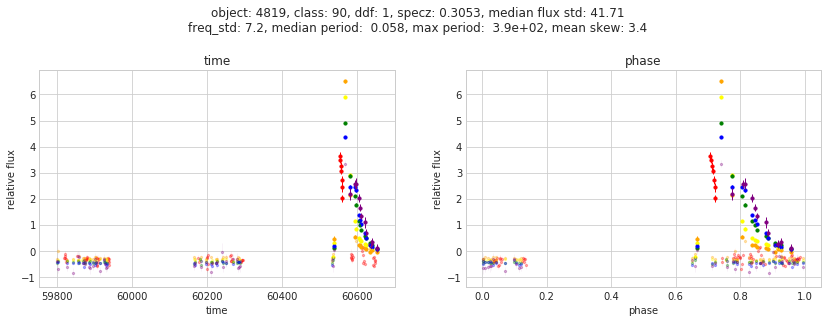

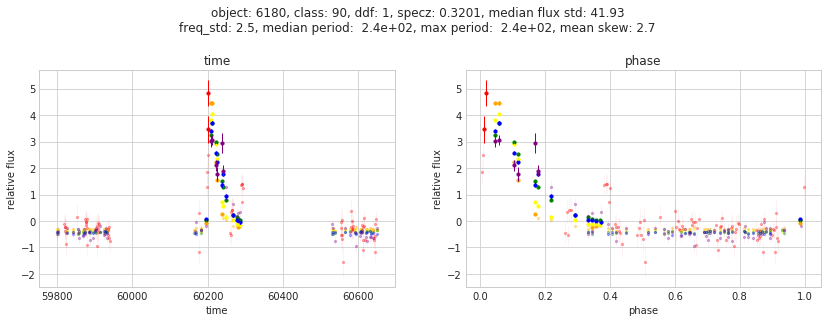

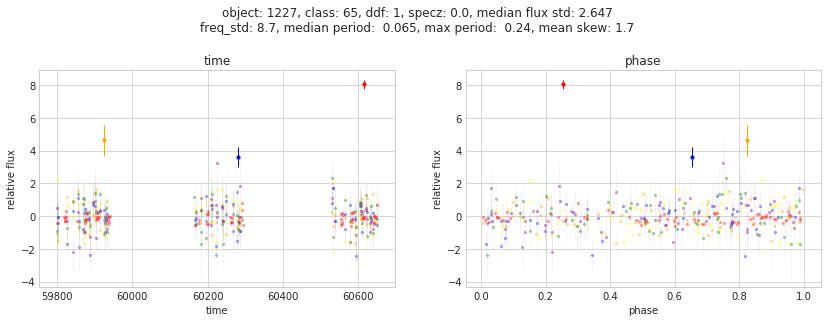

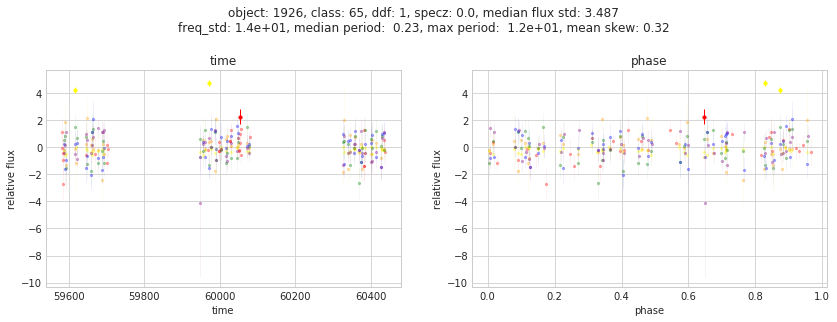

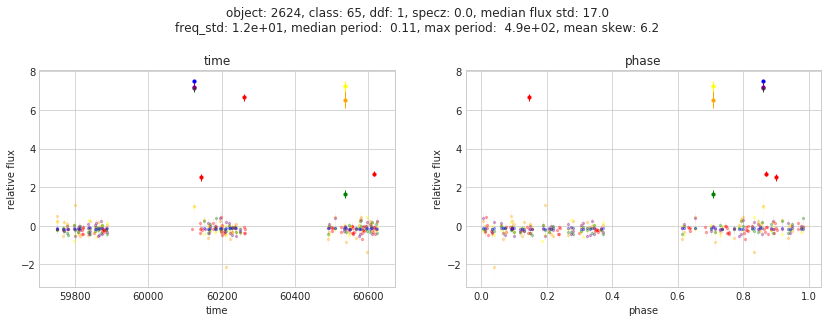

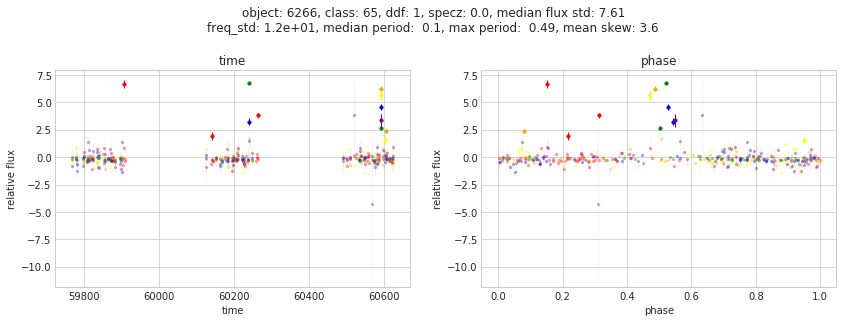

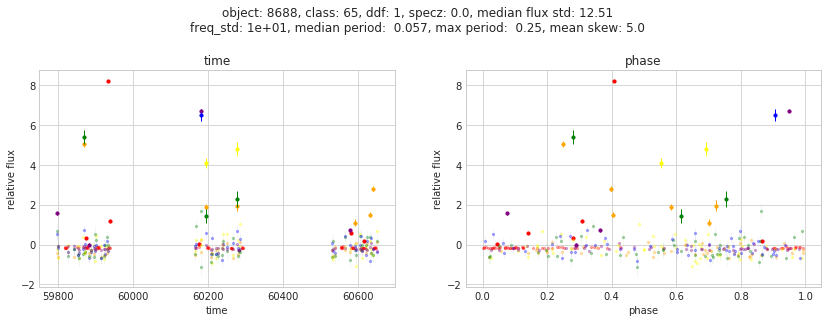

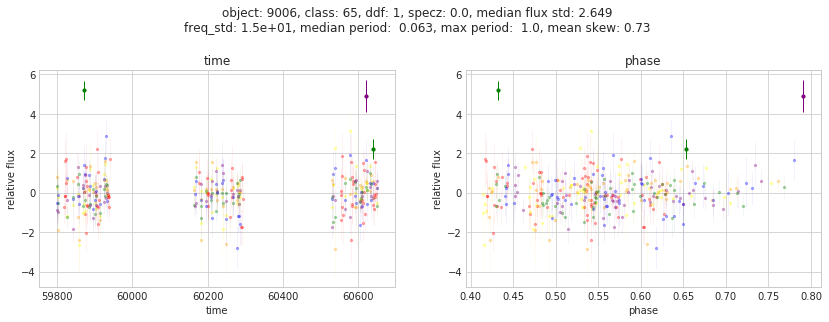

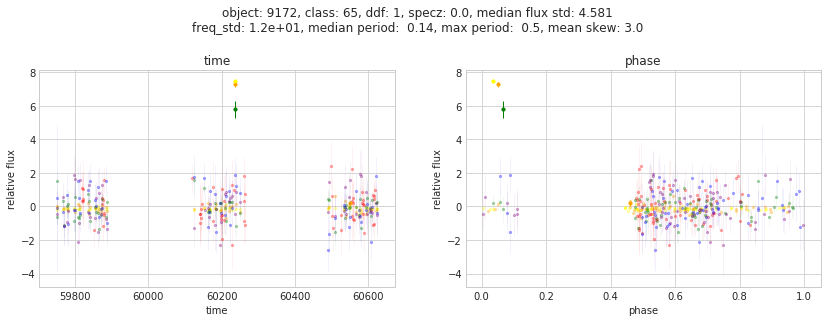

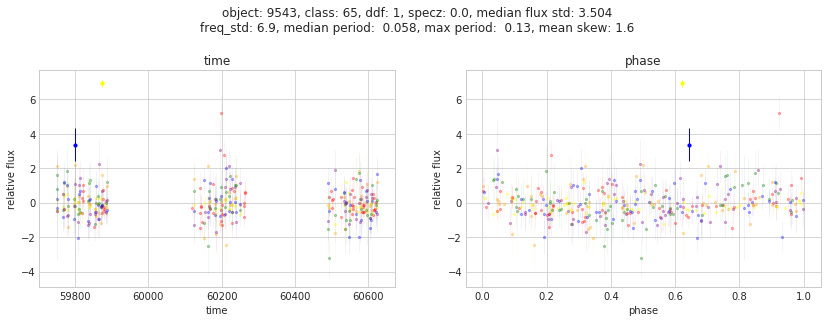

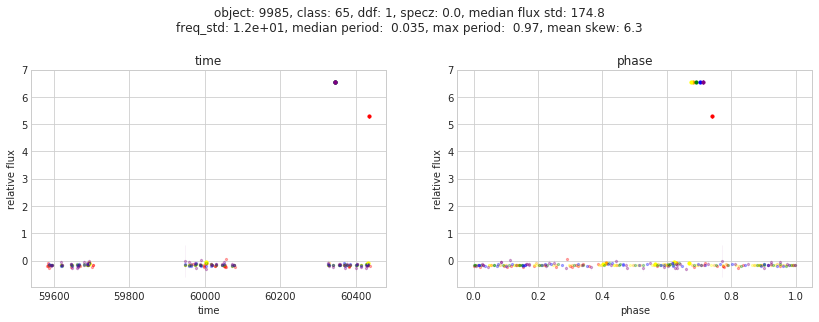

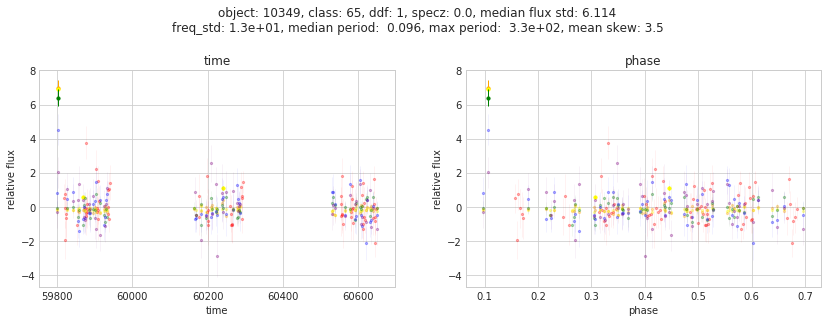

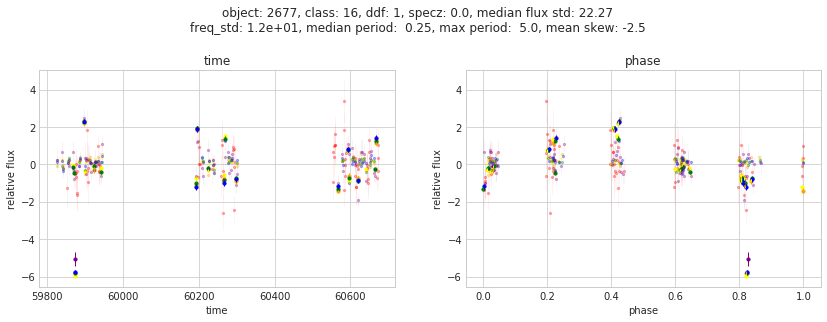

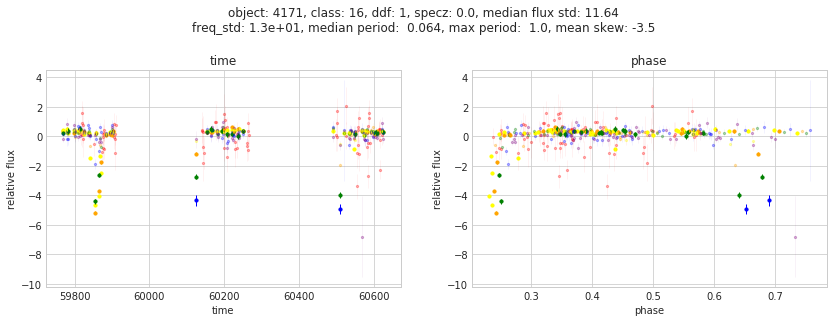

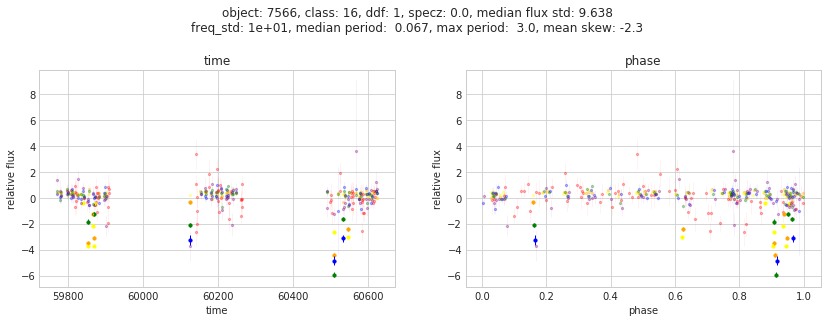

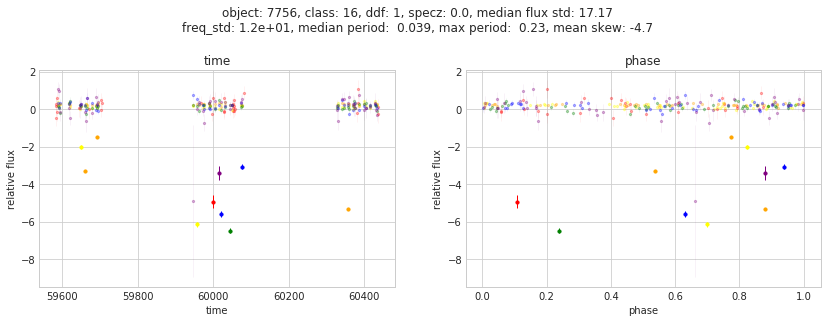

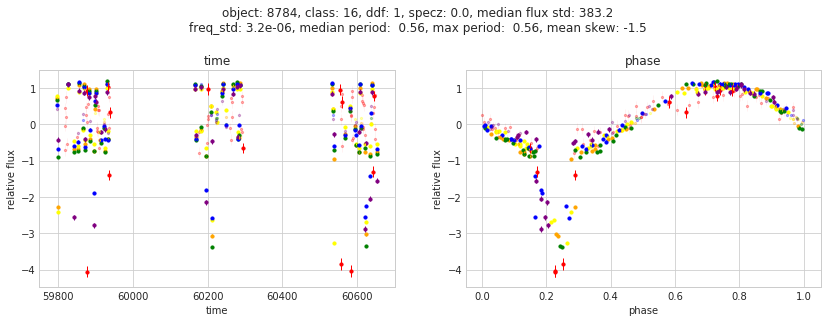

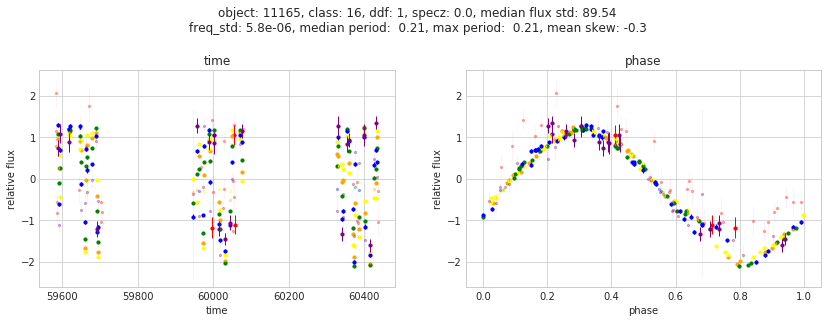

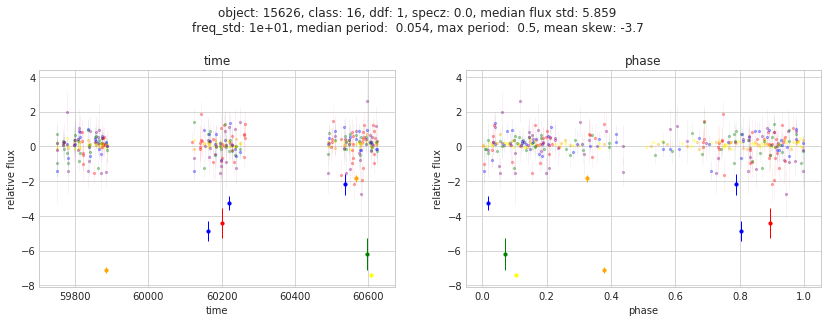

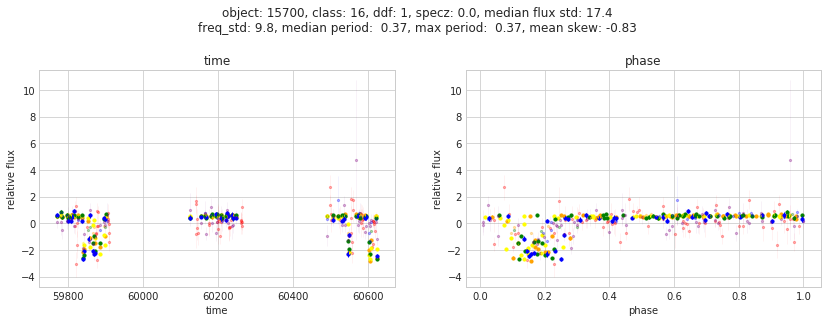

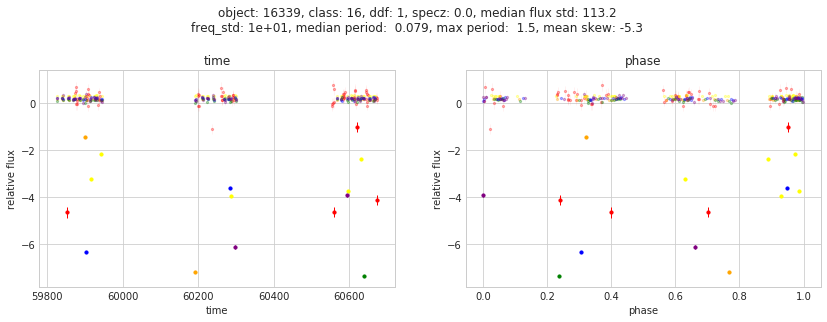

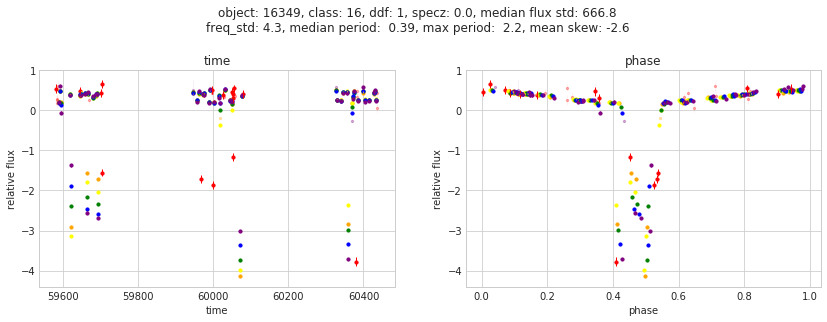

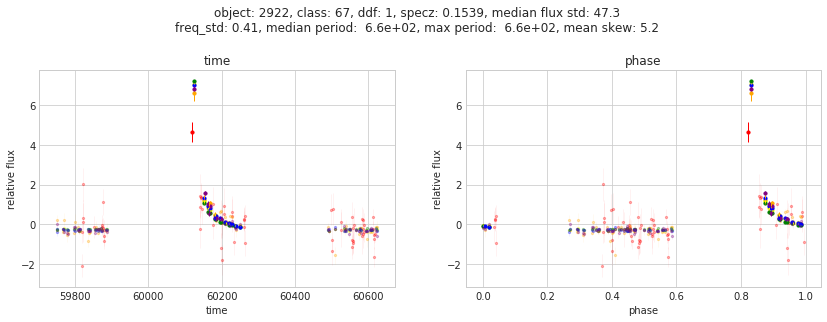

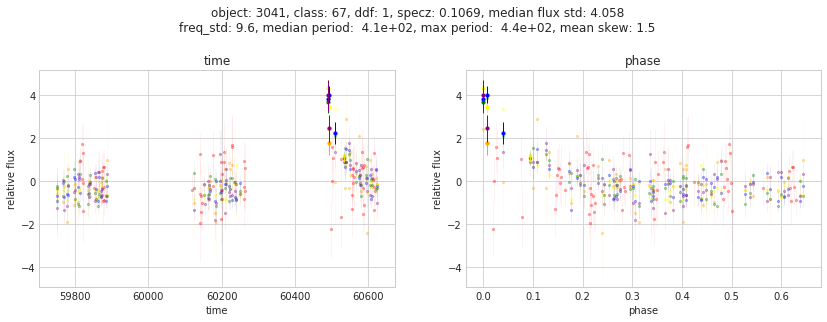

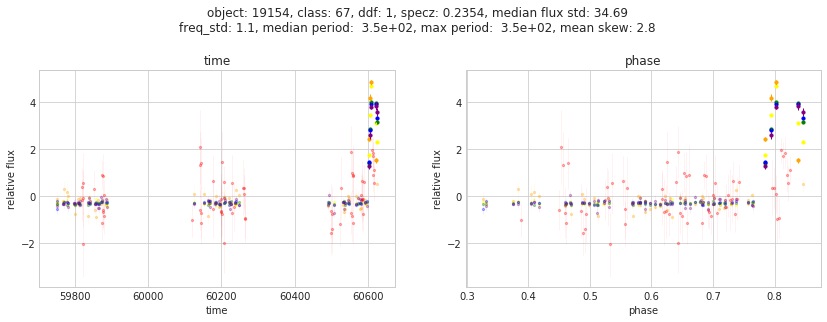

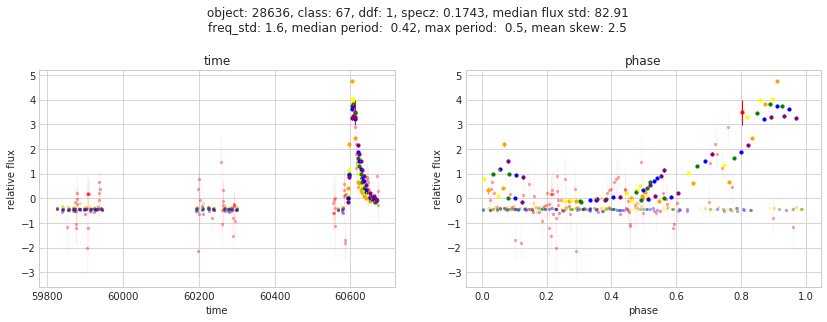

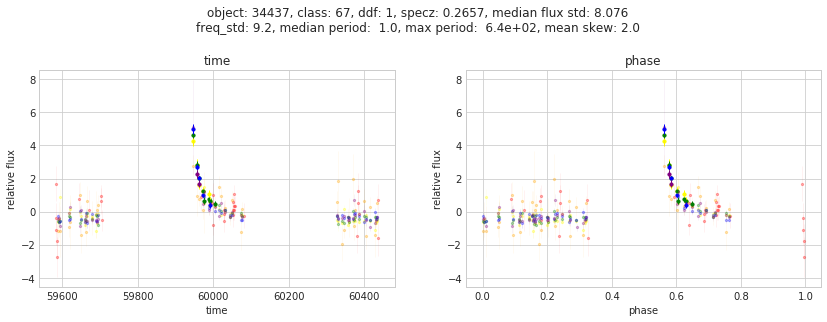

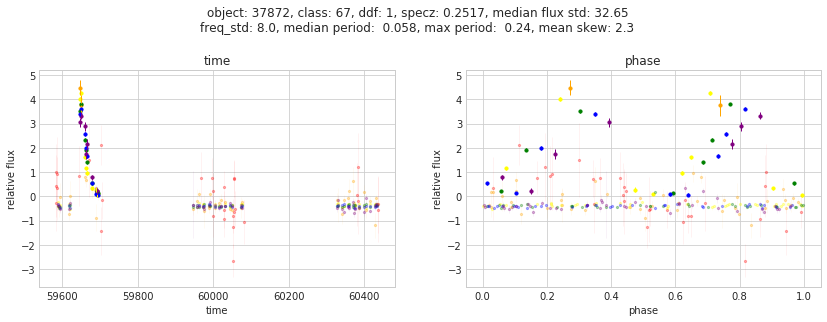

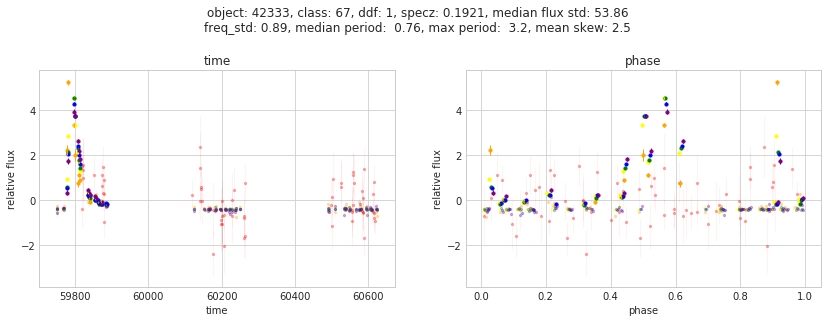

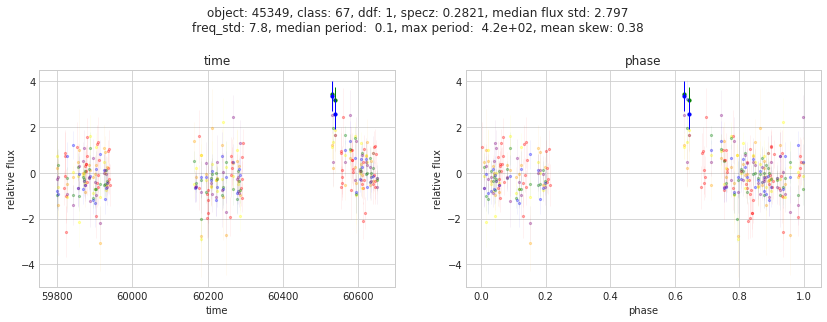

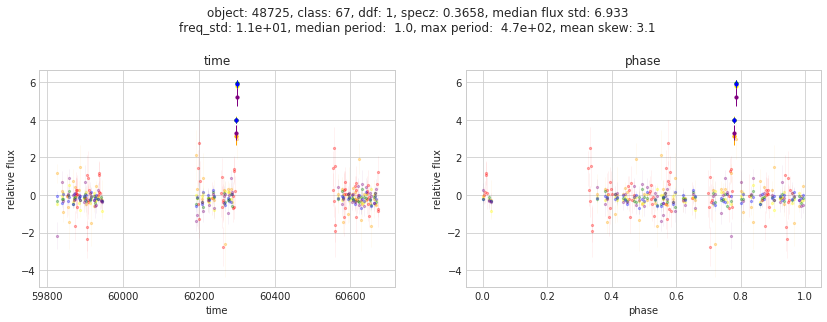

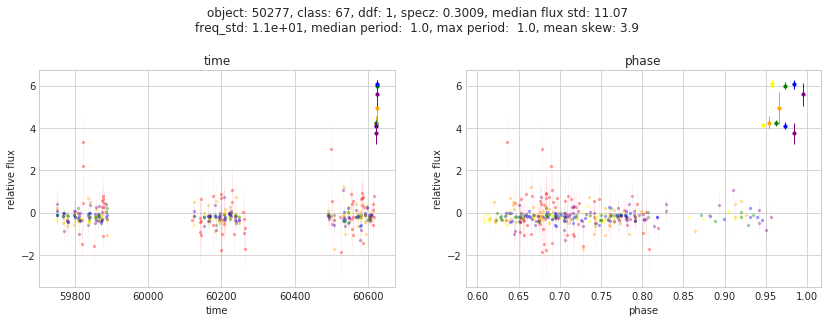

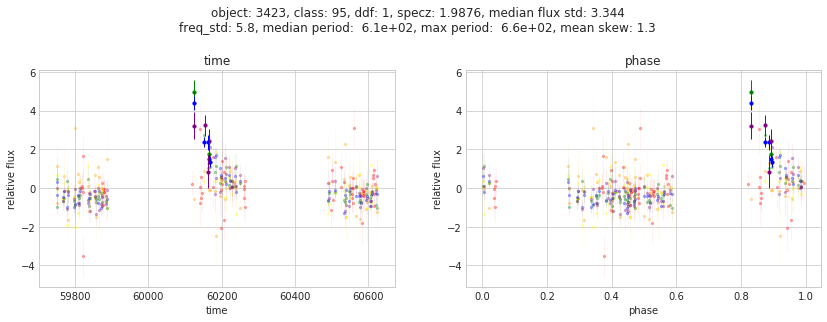

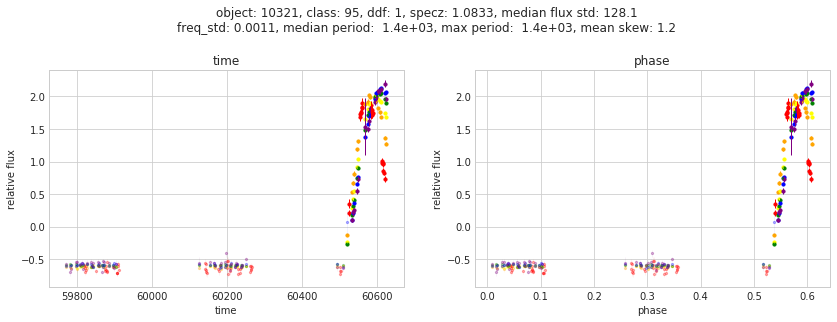

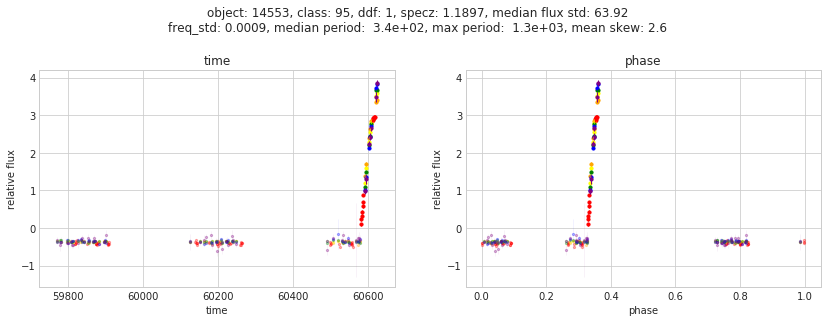

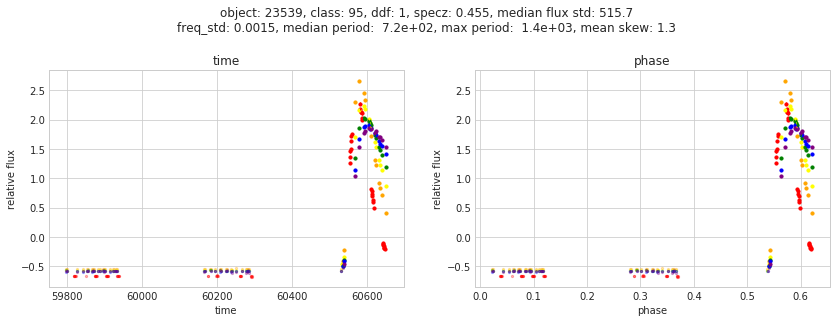

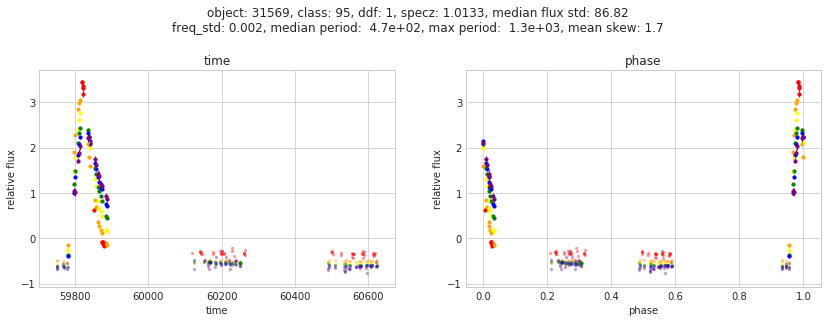

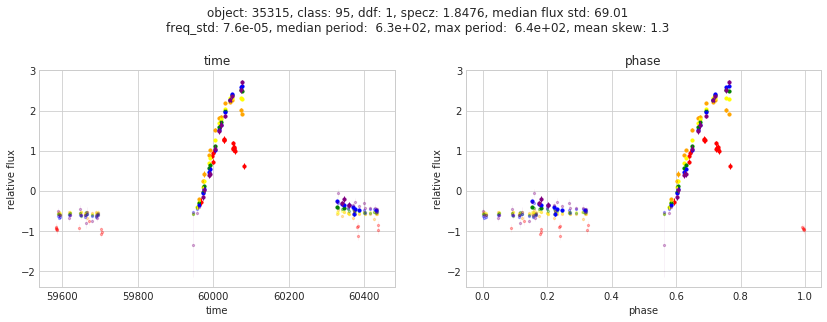

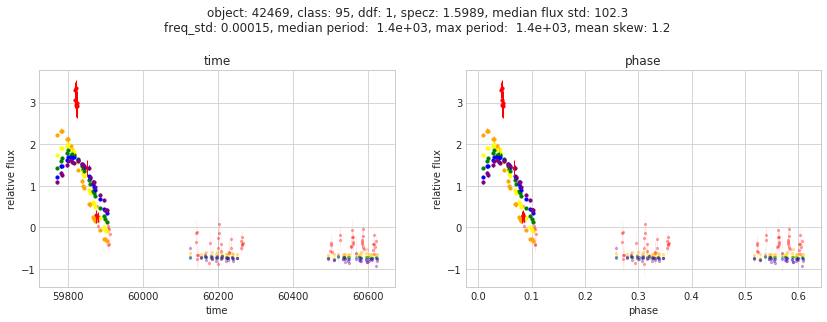

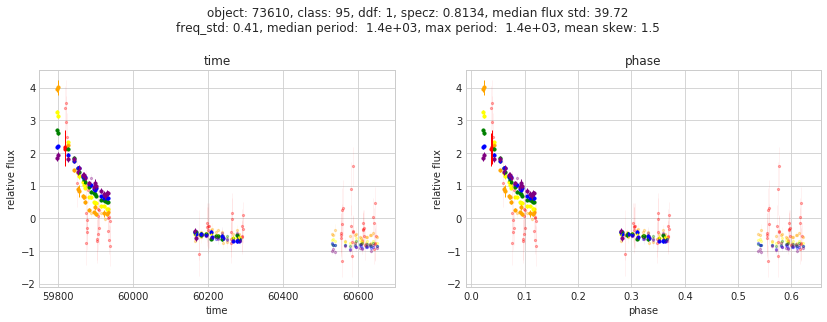

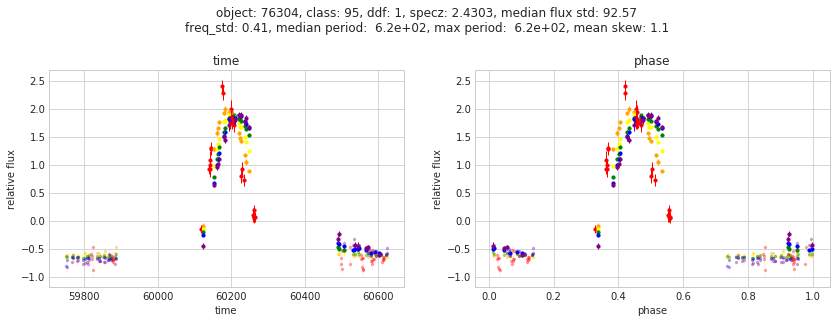

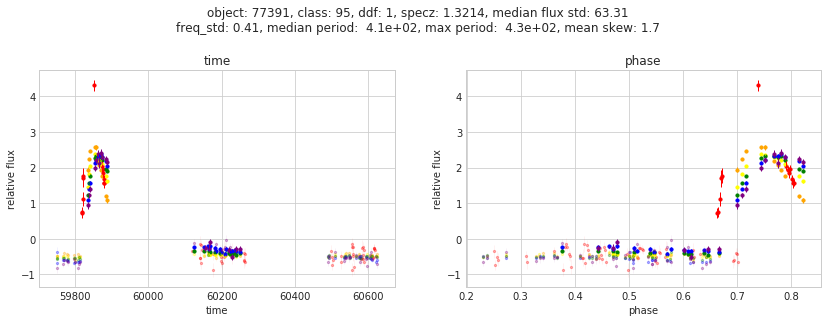

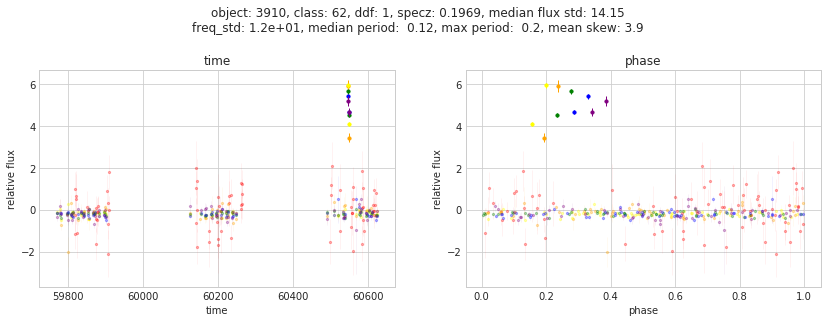

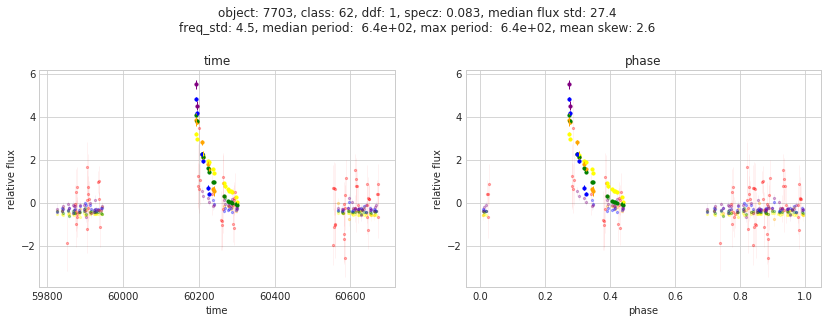

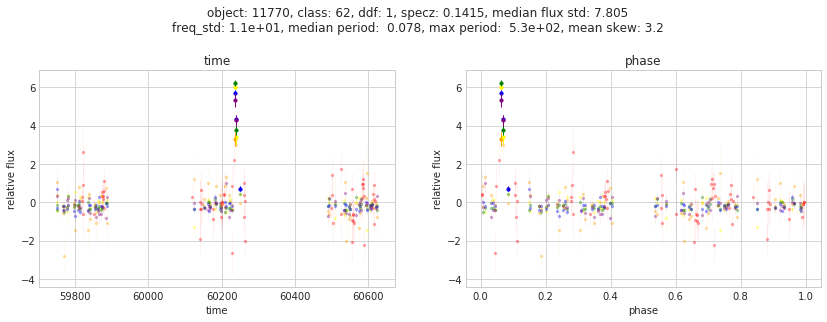

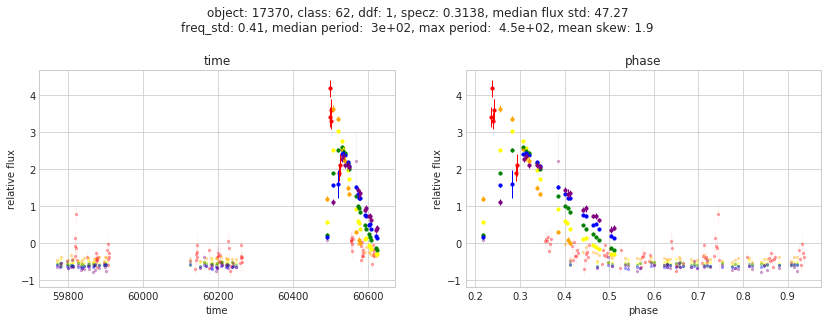

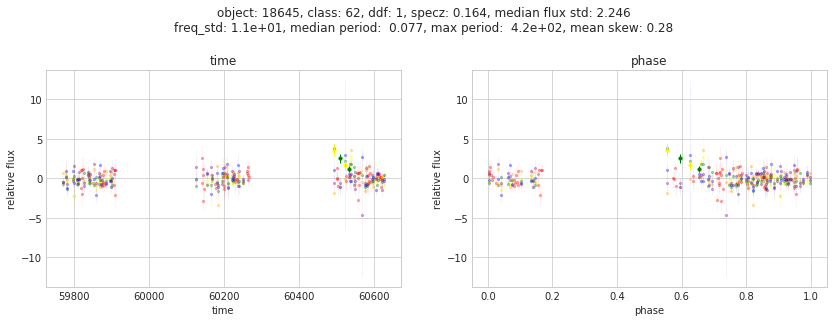

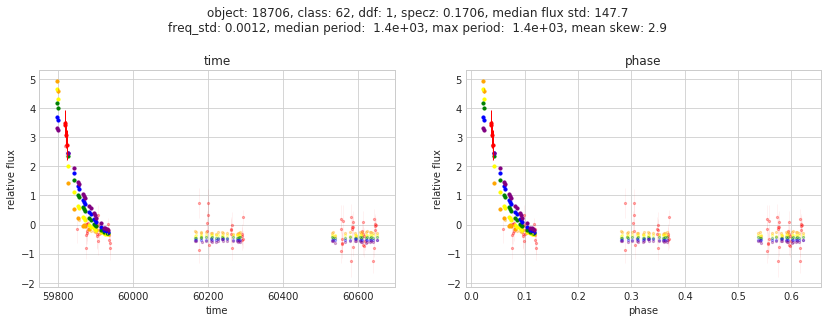

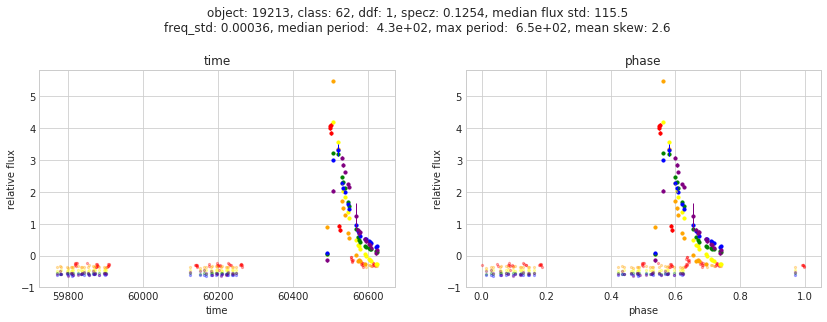

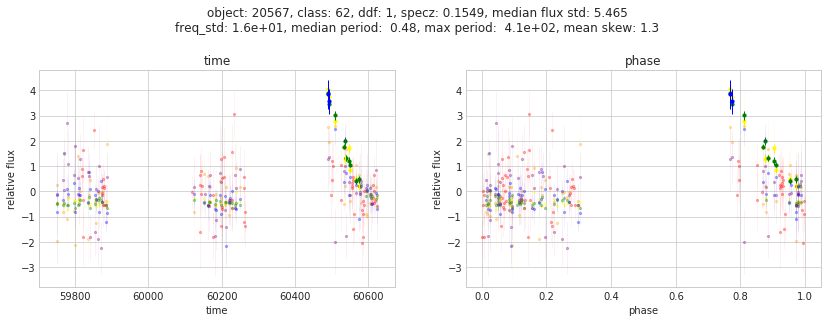

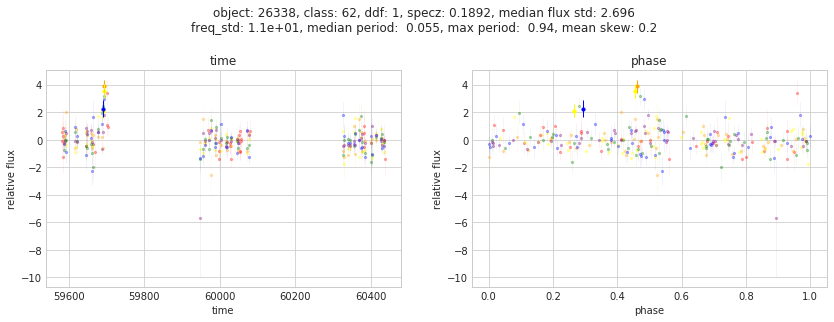

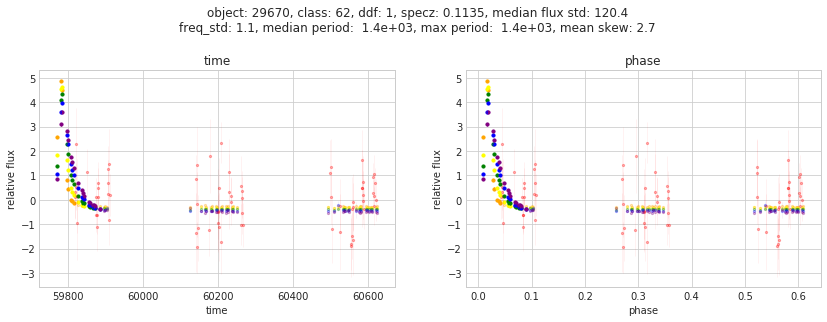

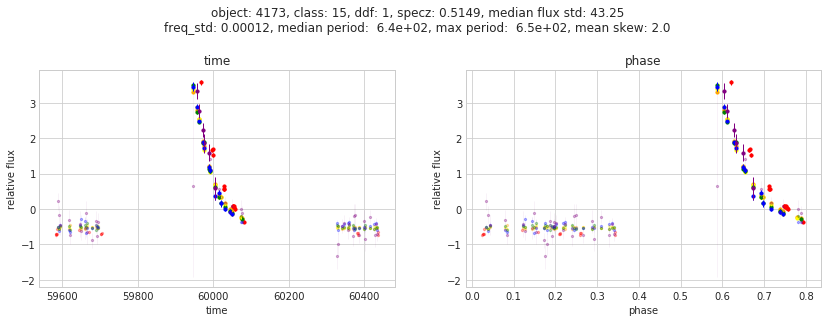

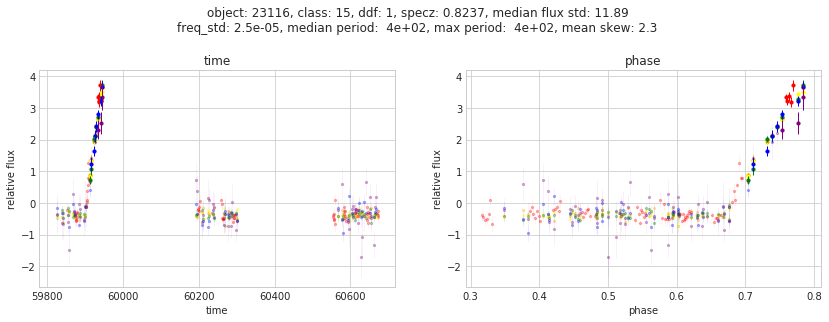

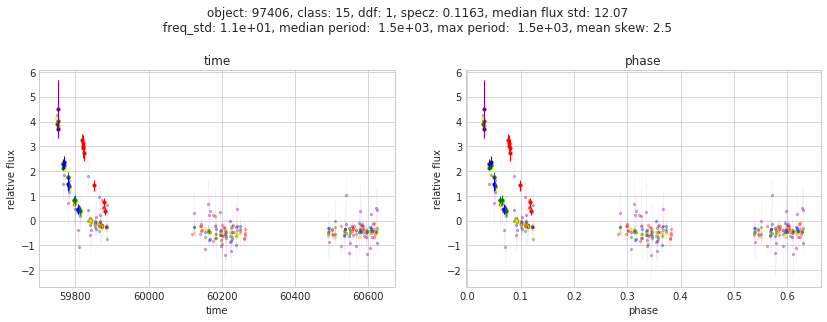

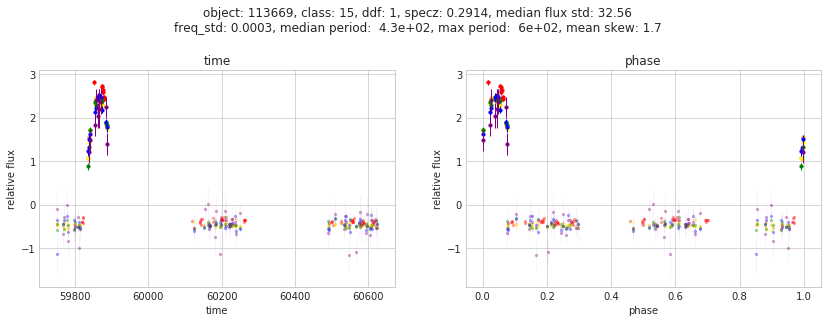

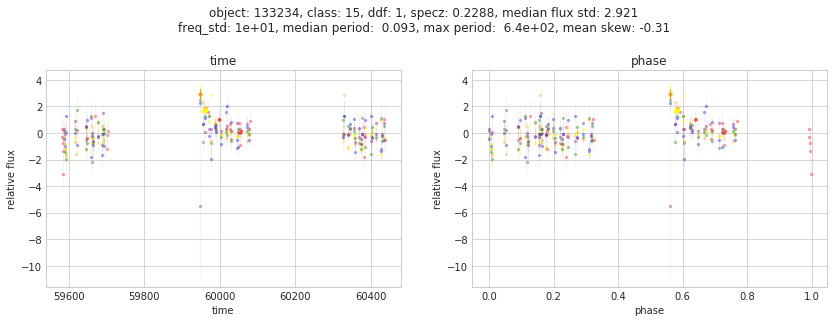

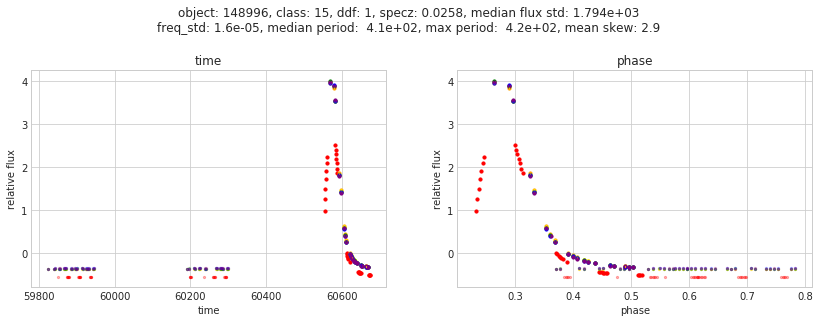

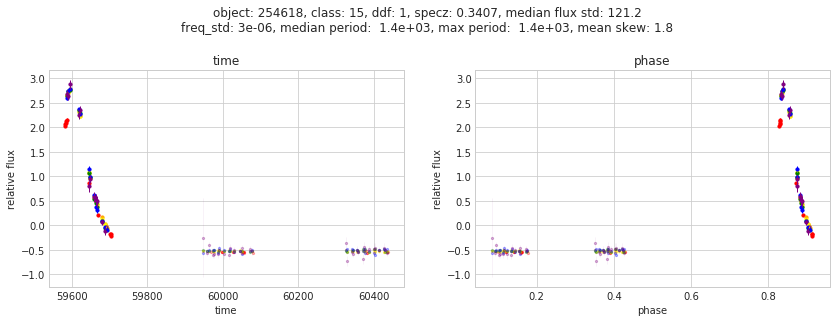

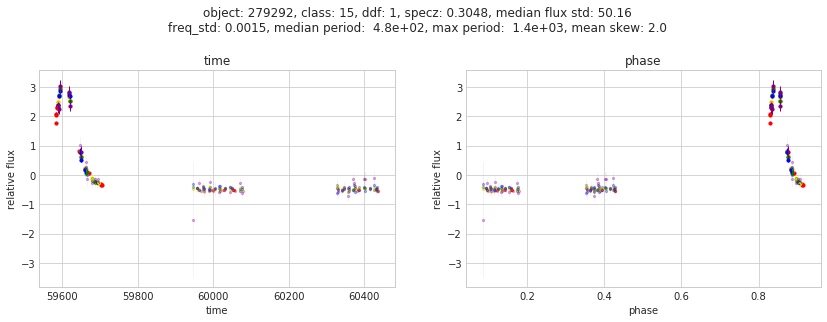

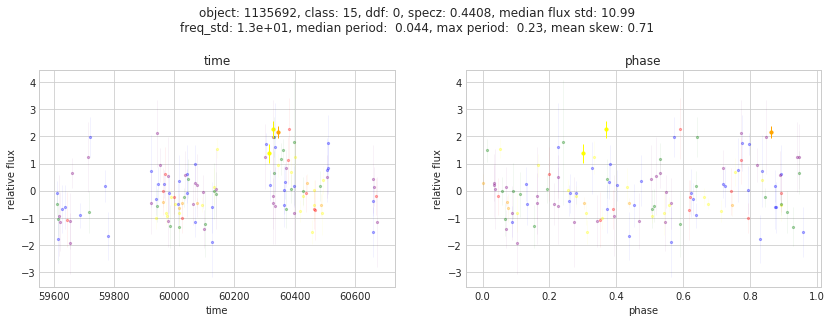

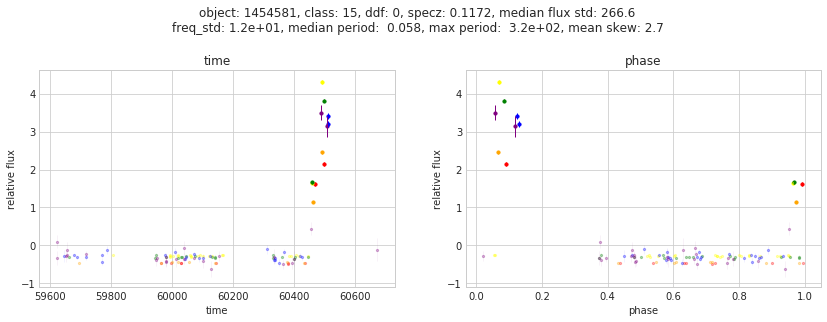

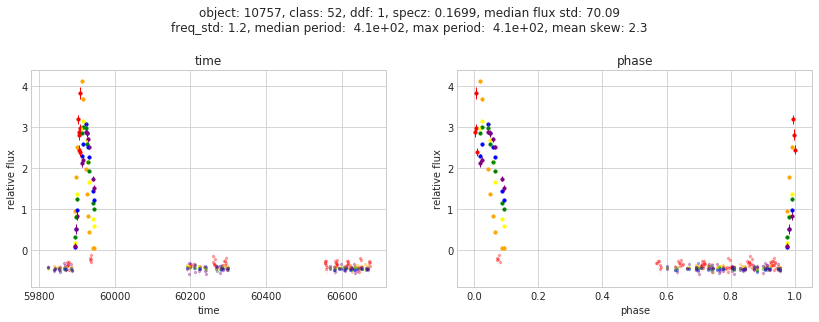

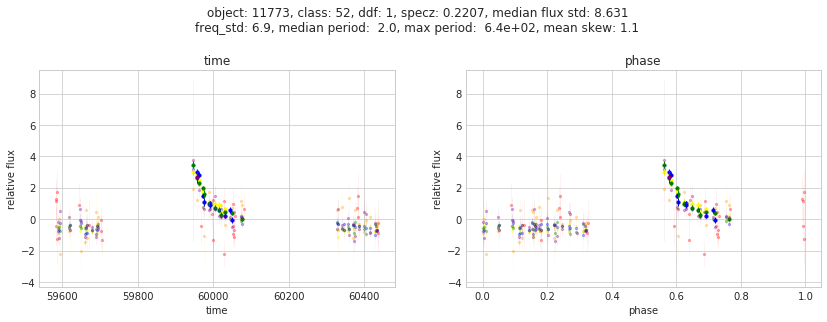

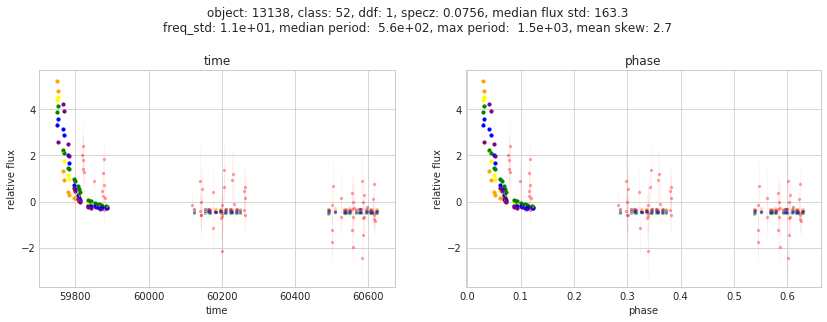

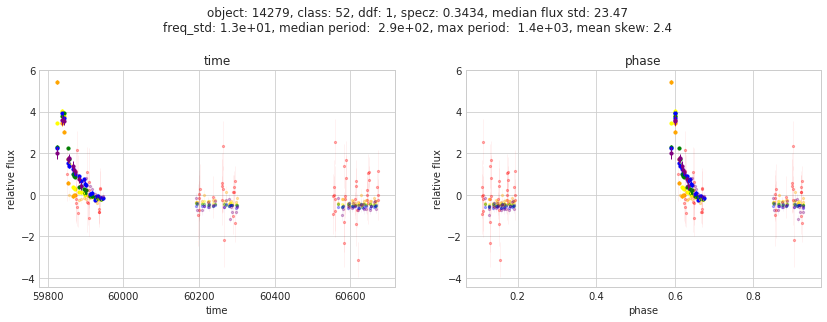

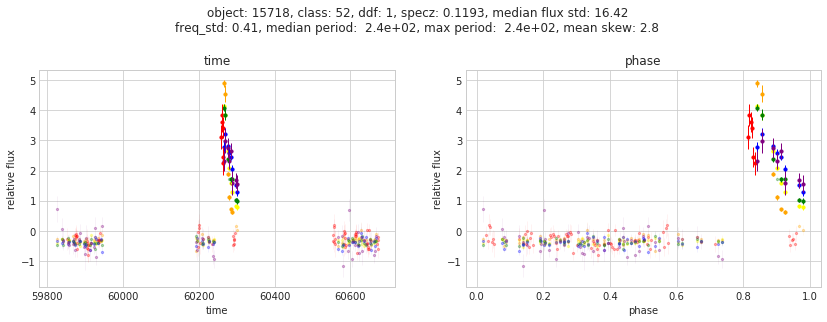

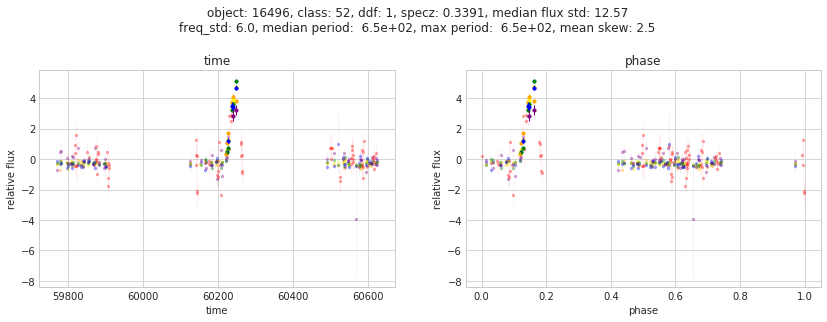

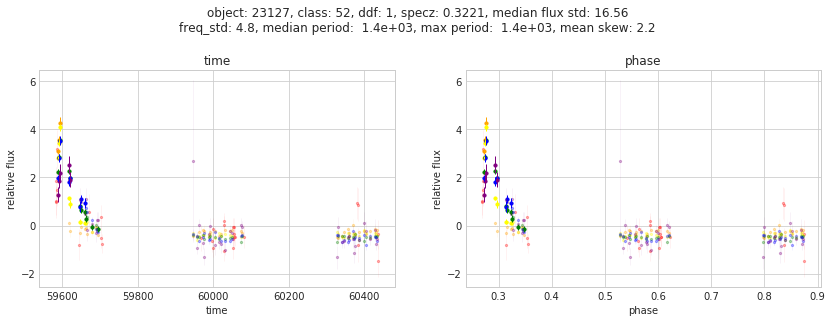

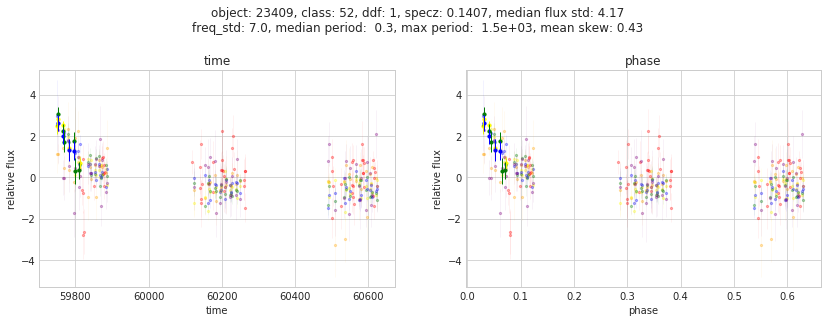

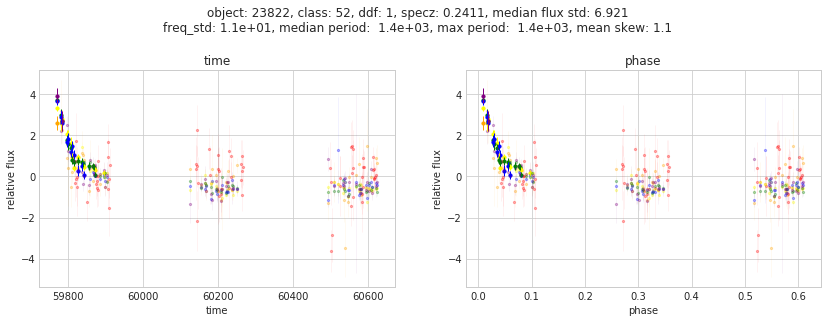

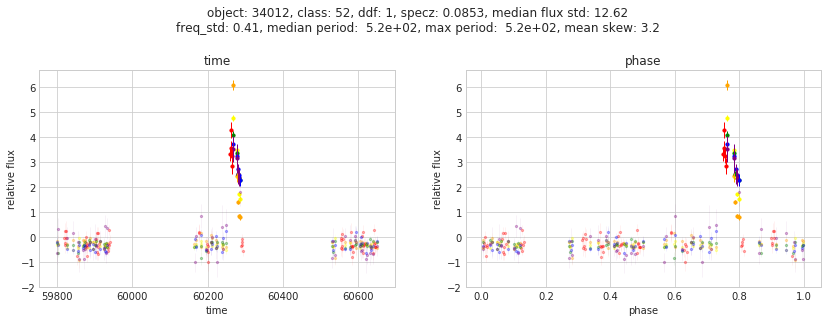

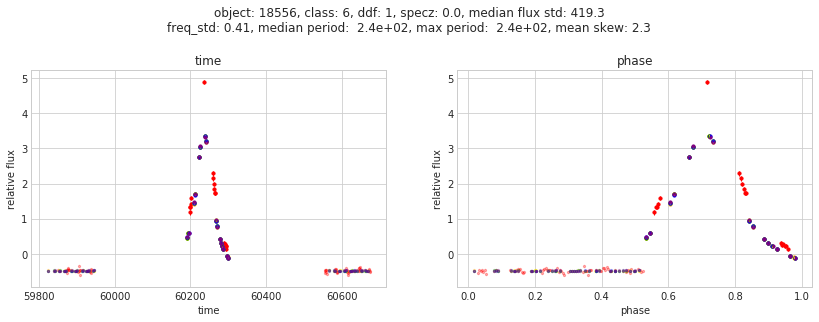

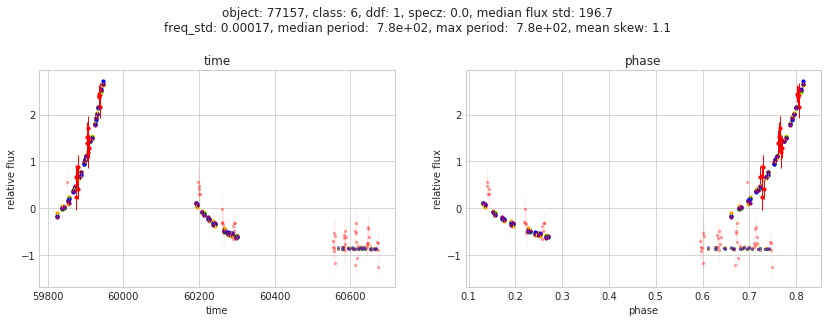

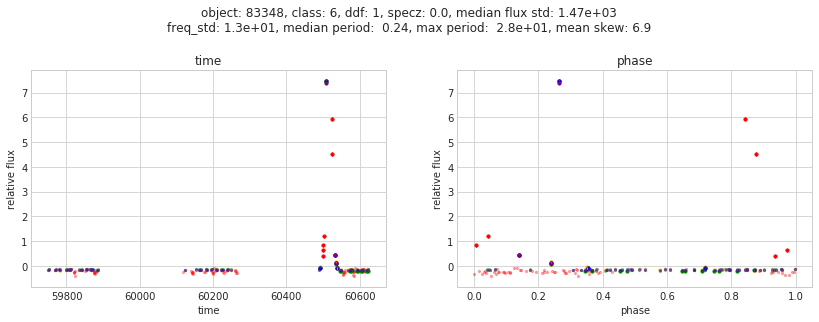

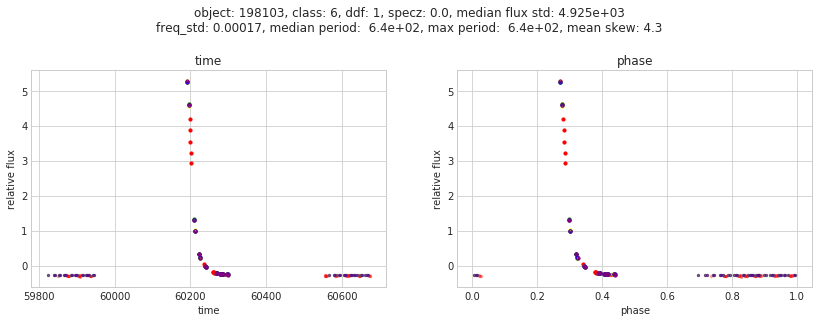

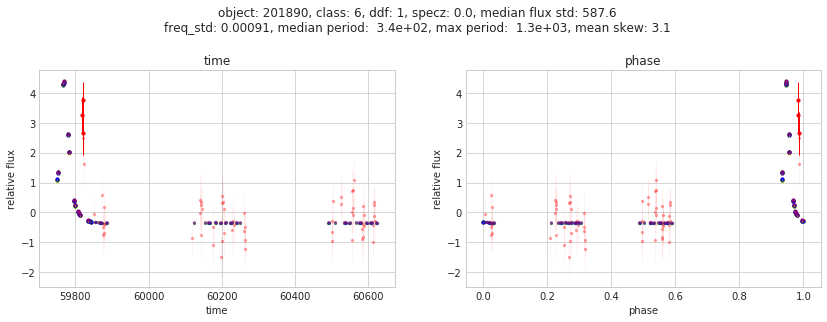

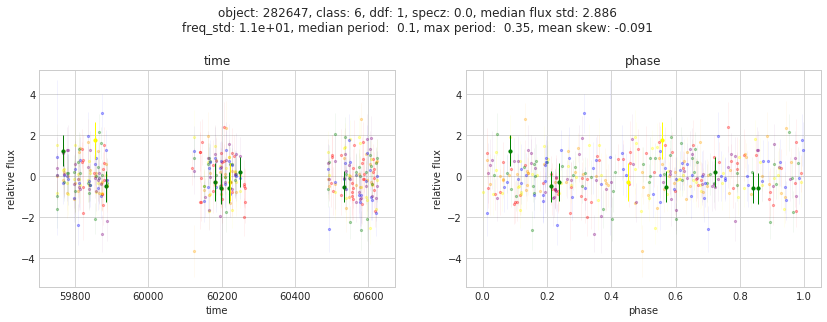

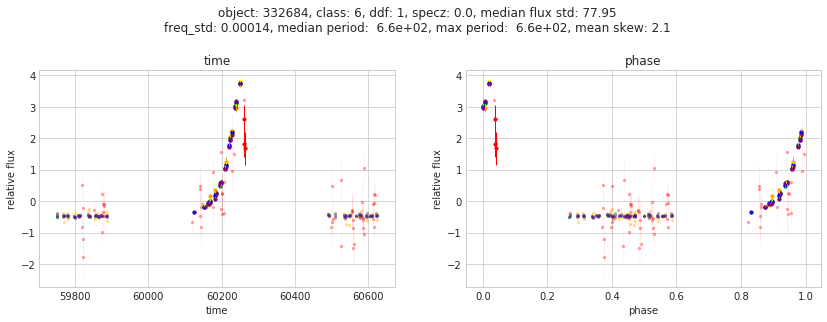

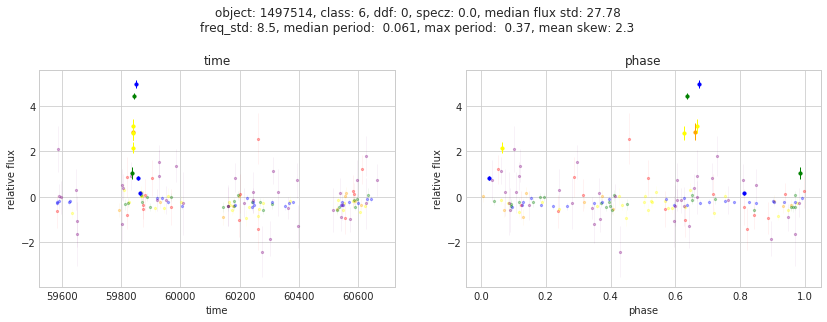

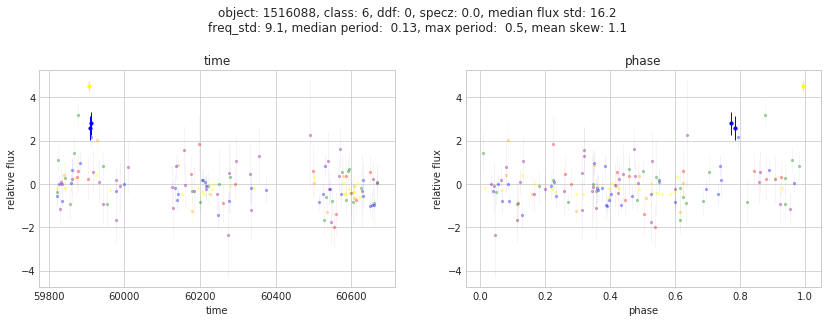

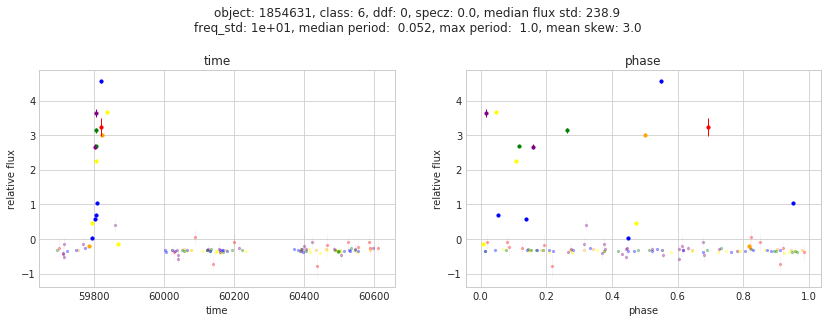

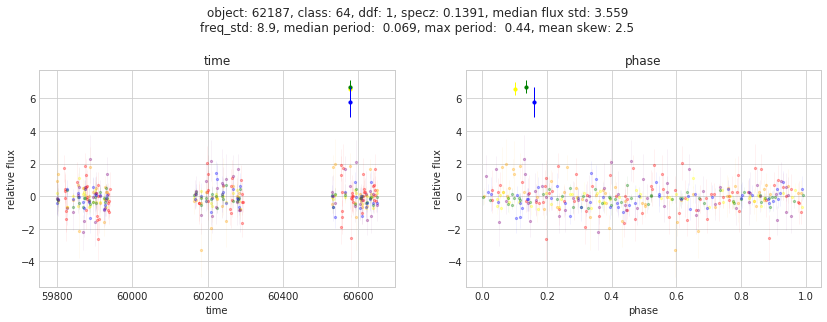

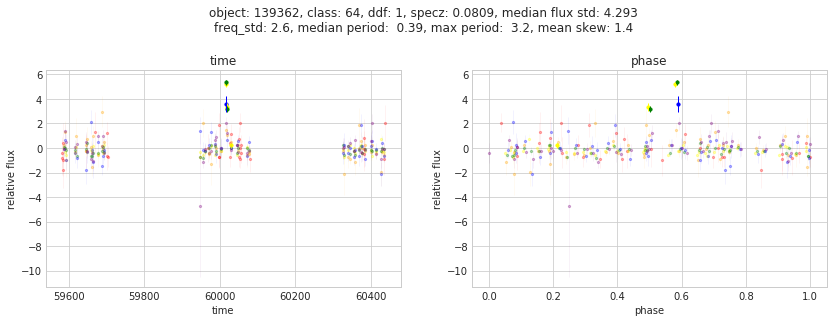

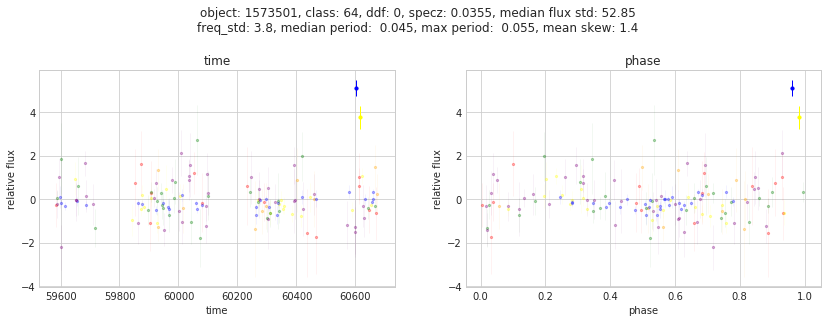

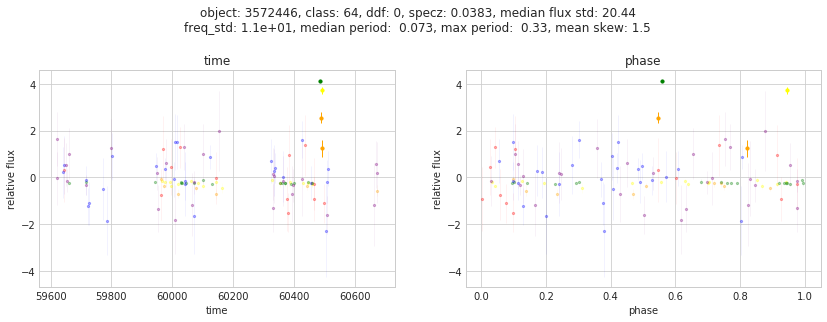

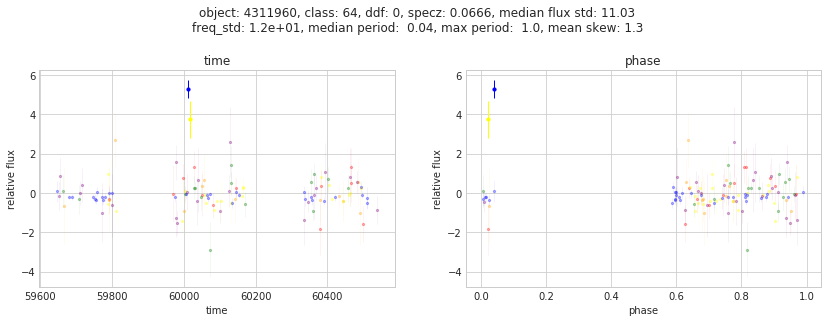

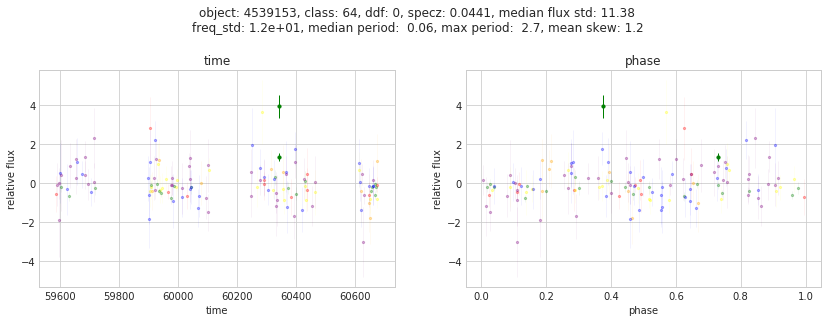

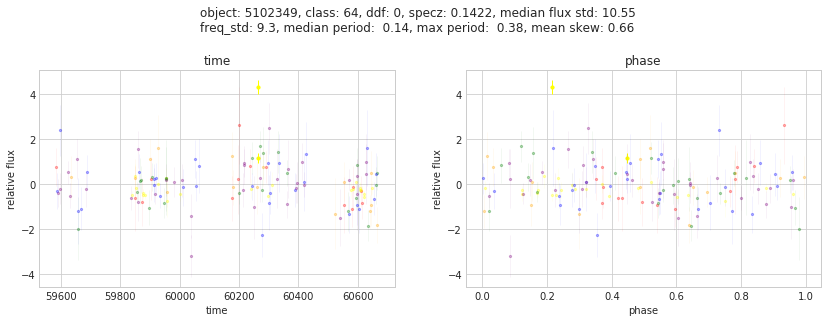

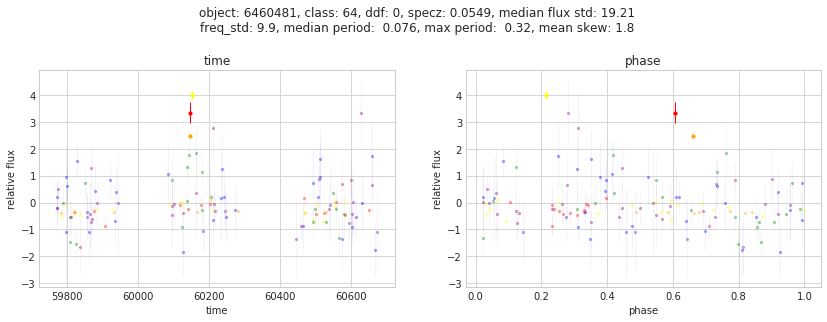

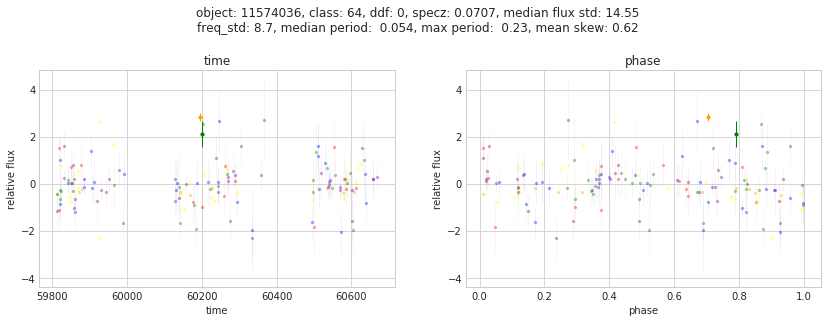

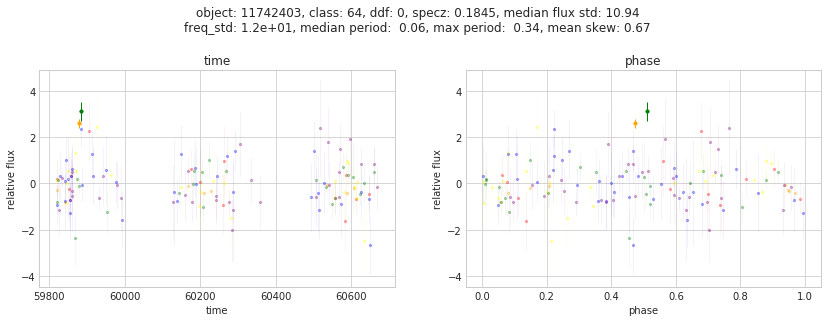

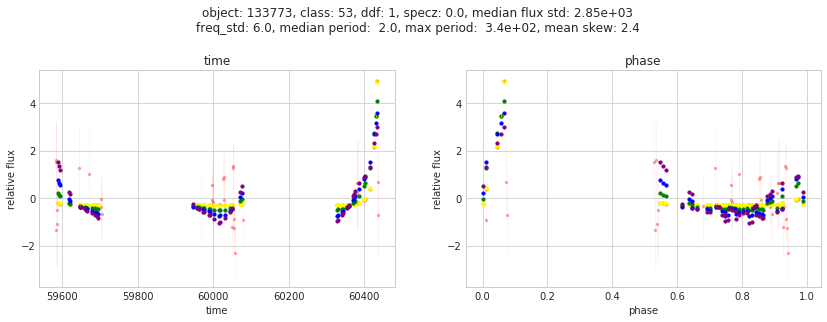

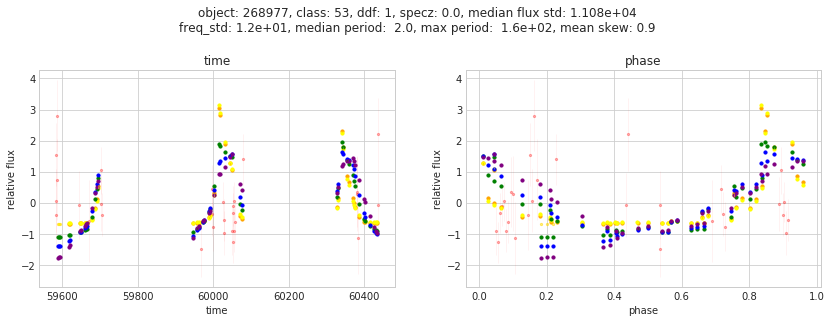

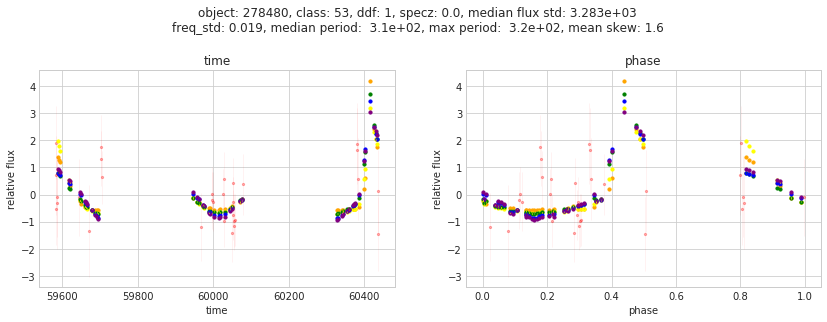

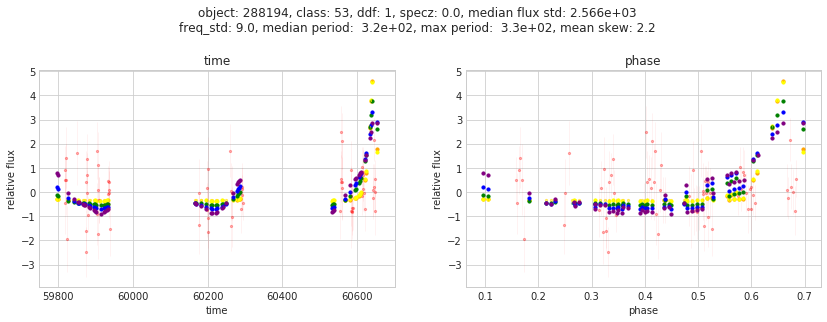

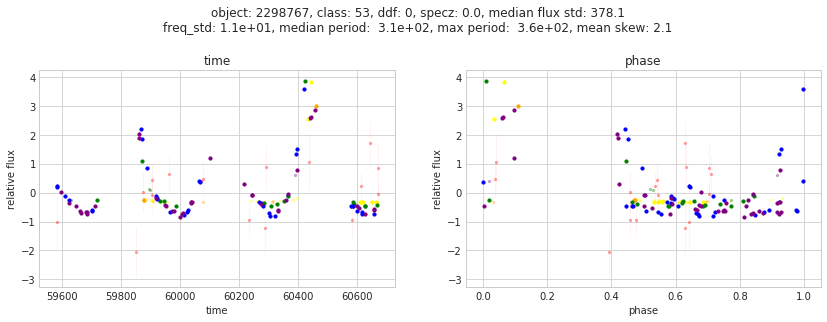

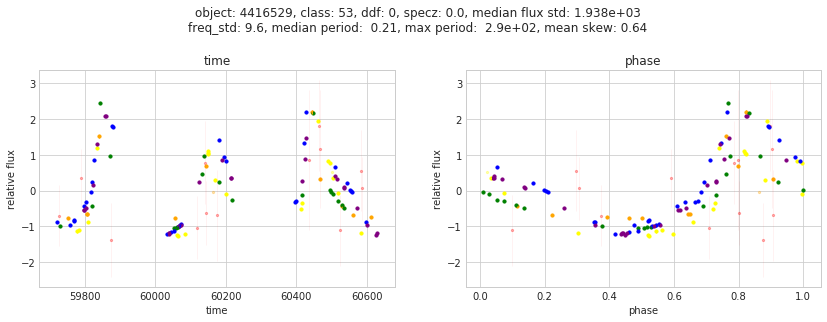

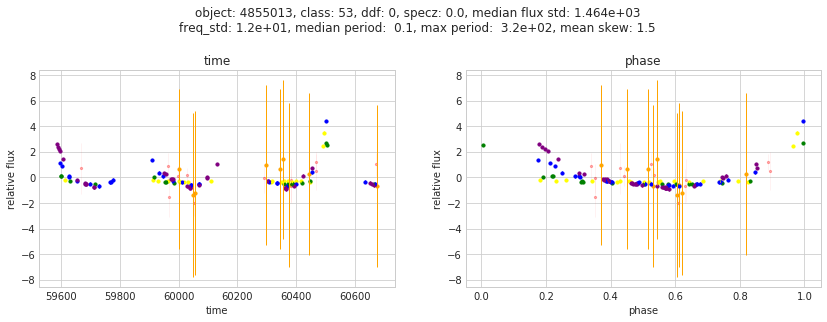

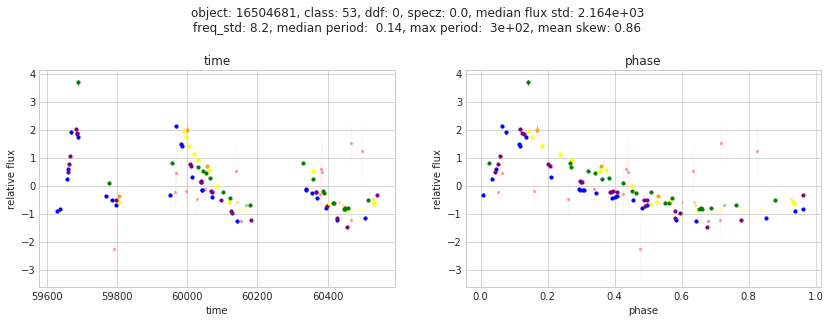

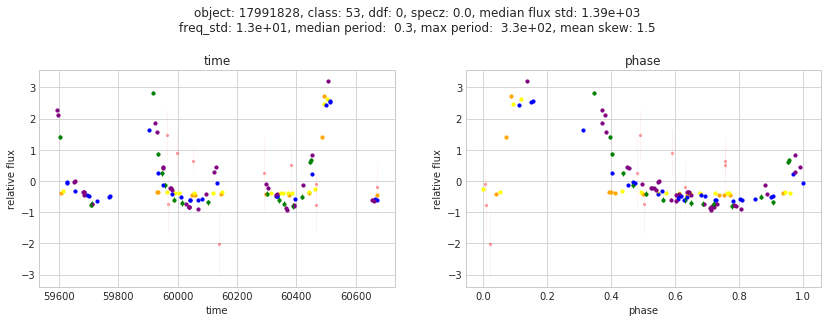

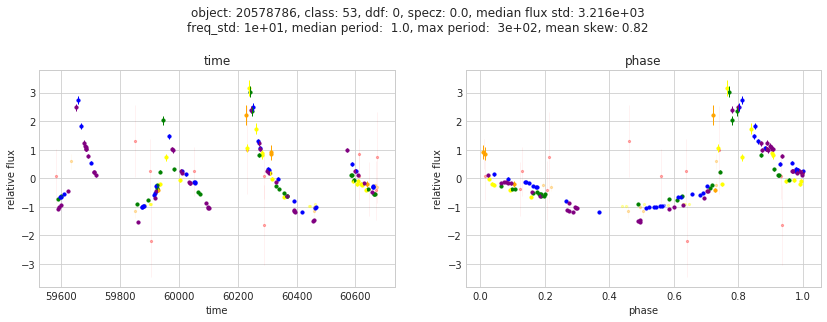

In [59]:
for c in unique_classes:
    plot_phase_curves(get_class_feats(c))